In [1]:
set.seed(1234)

library("here")
library(devtools)
library(Seurat)
library(harmony)
library(RcppML)

devtools::load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/proso_millet/QC_output/"

here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Attaching SeuratObject

Loading required package: Rcpp

ℹ Loading Socrates
Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory materia

In [97]:
rep_1 <- paste0(data_path,"panicum_millet.rep_1.merged_QC_soc_obj.rds")
rep_2 <- paste0(data_path,"panicum_millet.rep_2.merged_QC_soc_obj.rds")
prefix <- "Pm_leaf.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("rep1", "rep2")


print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj




[1] "Merging Object"
[1] "Generating Socrates Obj"


In [98]:
library(tidyverse)
as_tibble(merged.obj$meta)  %>% 
    group_by(sampleID)  %>% 
    summarise(mean_total = mean(total),
                           mean_tss = mean(tss),
                            mean_acrs = mean(acrs),
             mean_nSites = mean(nSites))

sampleID mean_total mean_tss mean_acrs mean_nSites
1 rep1     8558.154   3572.538 6793.136  4851.329   
2 rep2     6956.060   2910.050 5667.806  3818.549

In [99]:
    print("Generating Graphs")
    # estimate log10 number of accessible regions per cell
    cell.counts <- Matrix::colSums(soc.obj$counts)

    # estimate peak accessibility frequency across cells
    site.freq <- Matrix::rowMeans(soc.obj$counts)

[1] "Generating Graphs"


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"9 x values <= 0 omitted from logarithmic plot"
Warning message in xy.coords(x, y, xlabel, ylabel, log):
"1 x value <= 0 omitted from logarithmic plot"


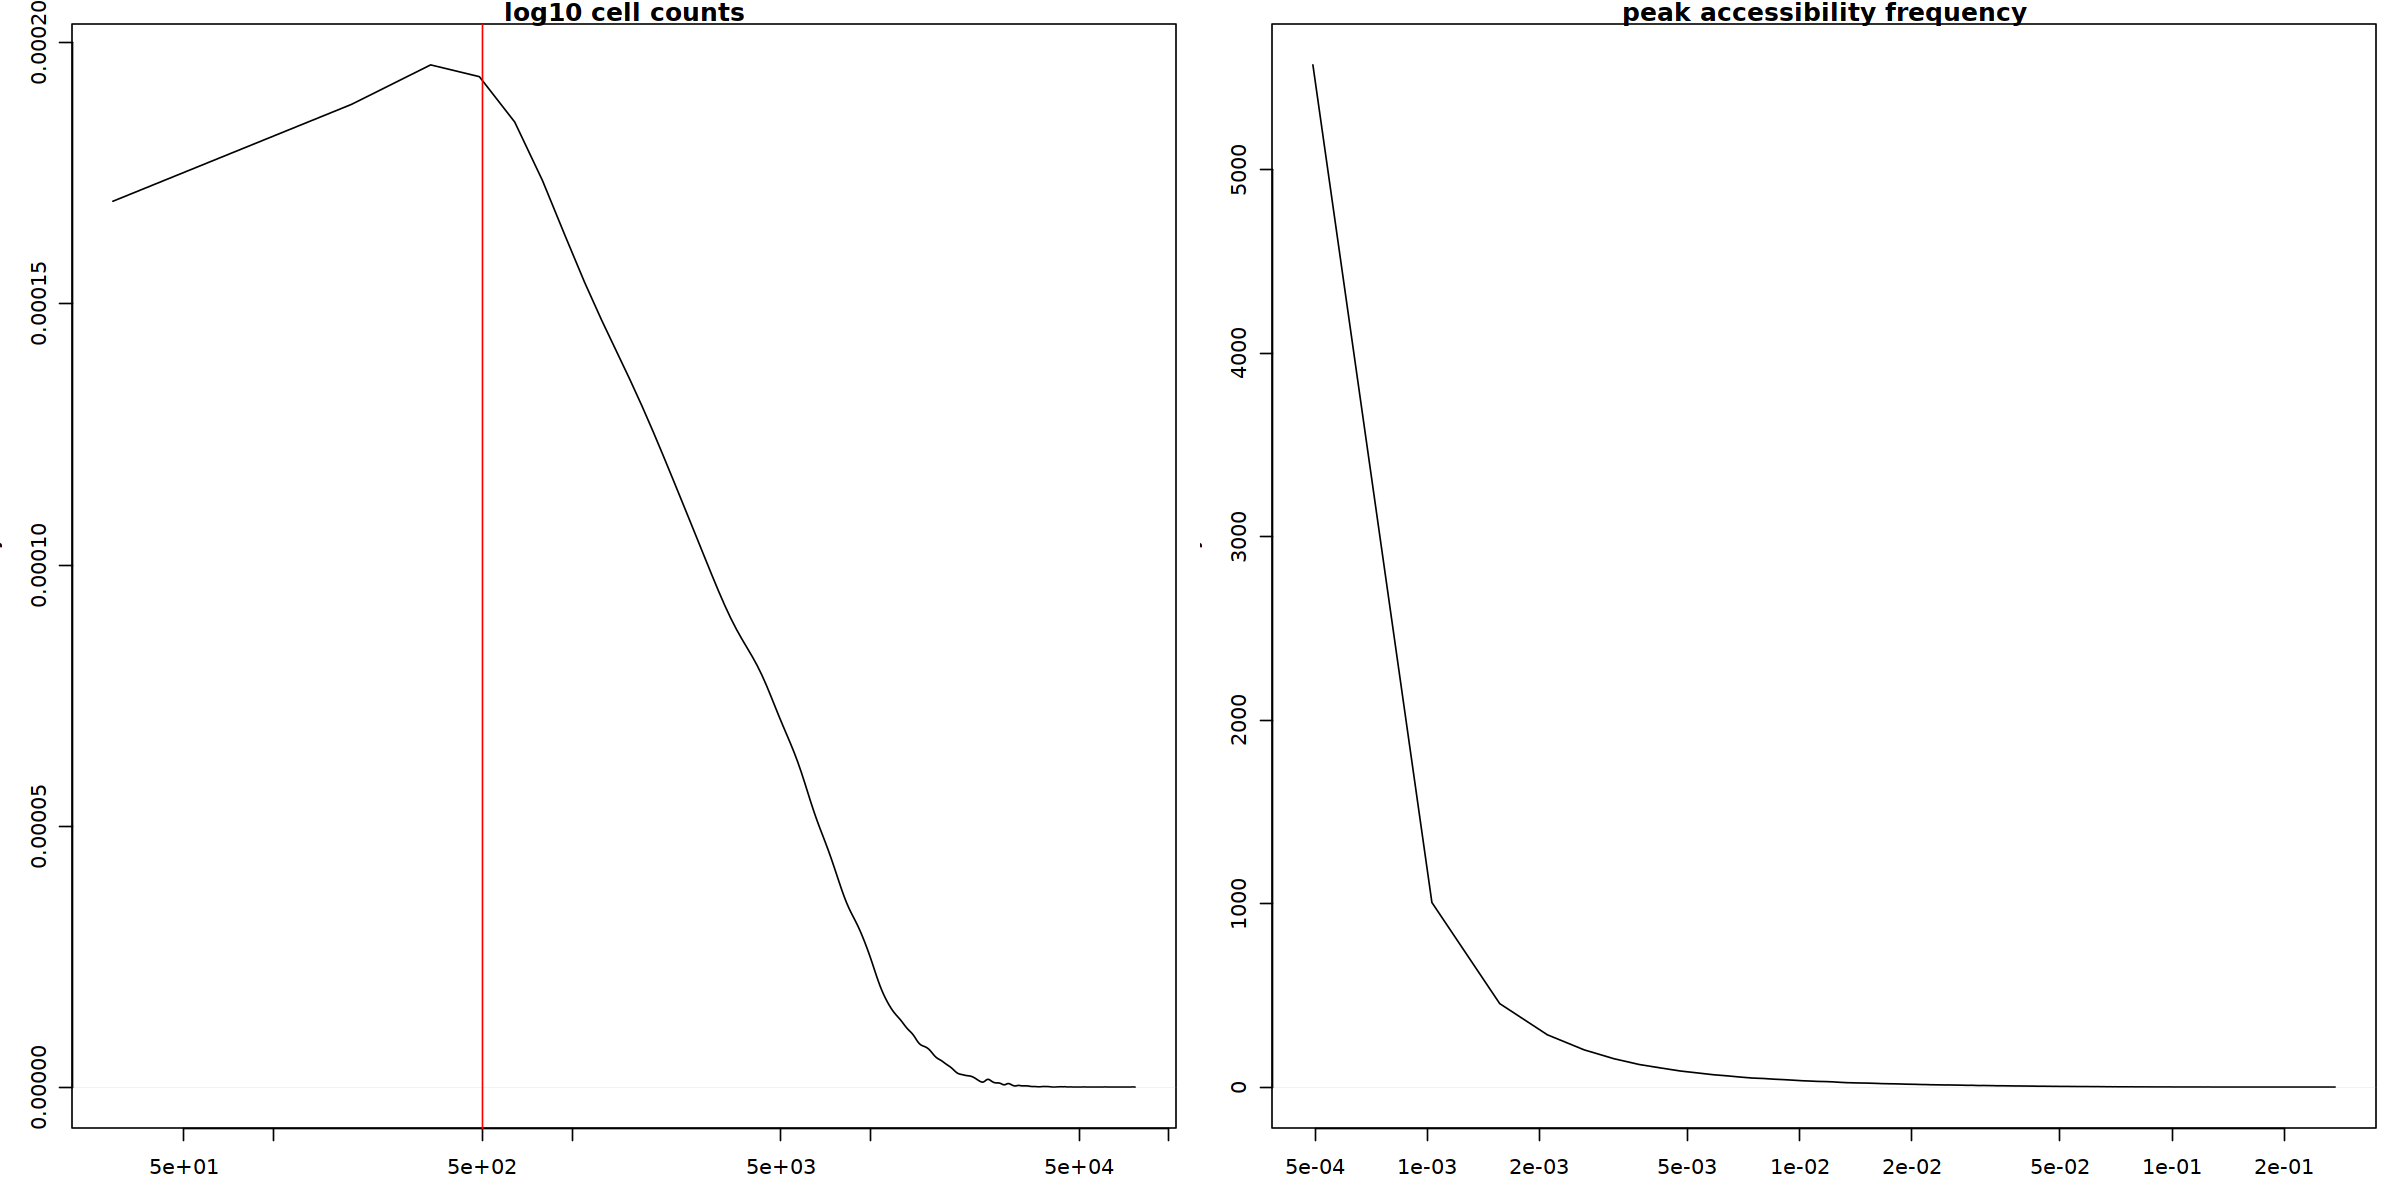

In [100]:
layout(matrix(c(1:2), ncol=2))
par(mar=c(3,3,1,1))
plot(density(cell.counts), main="log10 cell counts", log="x")
abline(v=500, col="red")
plot(density(site.freq), main="peak accessibility frequency", log="x")

In [101]:
# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)


# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=cell.counts.threshold,  # minimum number of accessible features per cell
                     min.t=0.02,  # minimum feature frequency across cells
                     max.t=0.1, # maximum feature frequency across cells
                     verbose=T)

   * Input: cells = 26303 | peaks = 1430939

   * Filtered: cells = 22439 | peaks = 55443



In [102]:
# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj)

In [103]:
# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="SVD", 
                      n.pcs=30, 
                      svd_slotName="SVD")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=25,
                       m.dist=0.01,
                       svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

11:56:24 UMAP embedding parameters a = 1.896 b = 0.8006

11:56:24 Read 22439 rows and found 30 numeric columns

11:56:24 Using Annoy for neighbor search, n_neighbors = 25

11:56:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:56:27 Writing NN index file to temp file /tmp/RtmpzzgKdz/file2800b117e125d

11:56:27 Searching Annoy index using 16 threads, search_k = 2500

11:56:28 Annoy recall = 100%

11:56:31 Commencing smooth kNN distance calibration using 16 threads
 with target n_neighbors = 25

11:56:35 Initializing from normalized Laplacian + noise (using irlba)

11:56:35 Commencing optimization for 200 epochs, with 933034 positive edges

11:57:13 Optimization finished



In [104]:
tfidf.obj.dob <- detectDoublets(soc.obj.project_umap, threads=10, nTrials=5, 
                                nSample=1000, rdMethod = "SVD", svd_slotName="SVD")

 - Creating synthetic doublets ...

 - Created 110000 synthetic doublets ...

 - Creating original projection ...

 - Merging synthetic and original cells ...

 - Projecting to UMAP ...

 - Computing KNN doublets (SVD)...

 - Computing KNN doublets (UMAP)...



In [105]:
tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=F, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

 - libraryVar: sampleID



In [106]:
remove_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered"))  %>% 
        ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)
    
    new_meta <- subset(old_meta, doubletscore < calculated_value) 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    new_meta$d.type <- "singlet"
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

remove_doublets <- function(obj) { 
    
    old_meta <- obj$meta

    new_meta <- subset(old_meta, d.type == "singlet") 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

filter_ptmt_ratio <- function(obj, ratio) { 
    
    old_meta <- obj$meta
    old_meta$ptmt_ratio <- old_meta$ptmt/old_meta$total
    

    new_meta <- subset(old_meta, ptmt_ratio < ratio) 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    
    obj$pre.ptmt_filter <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * PtMt filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}


plot_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered")) 

    
    return(grabbed_graph)

}

In [107]:
library(tidyverse)

#Generate Graphs for Comparison of Doublets
birthday_problem <- plot_top_x_doublet_percent(tfidf.obj.dob.filt)
birthday_problem_graph <- ggplot(birthday_problem, aes(doubletscore, color = filter_bool)) + 
geom_bar() + 
facet_grid(sampleID~.) + 
ggtitle("Birthday Problem")

archR_graph_1 <- as_tibble(tfidf.obj.dob.filt$meta) %>% 
    ggplot(., aes(doubletscore, color = d.type)) + geom_bar() + facet_grid(sampleID~.) + 
    ggtitle("ArchR Doublet Calls")

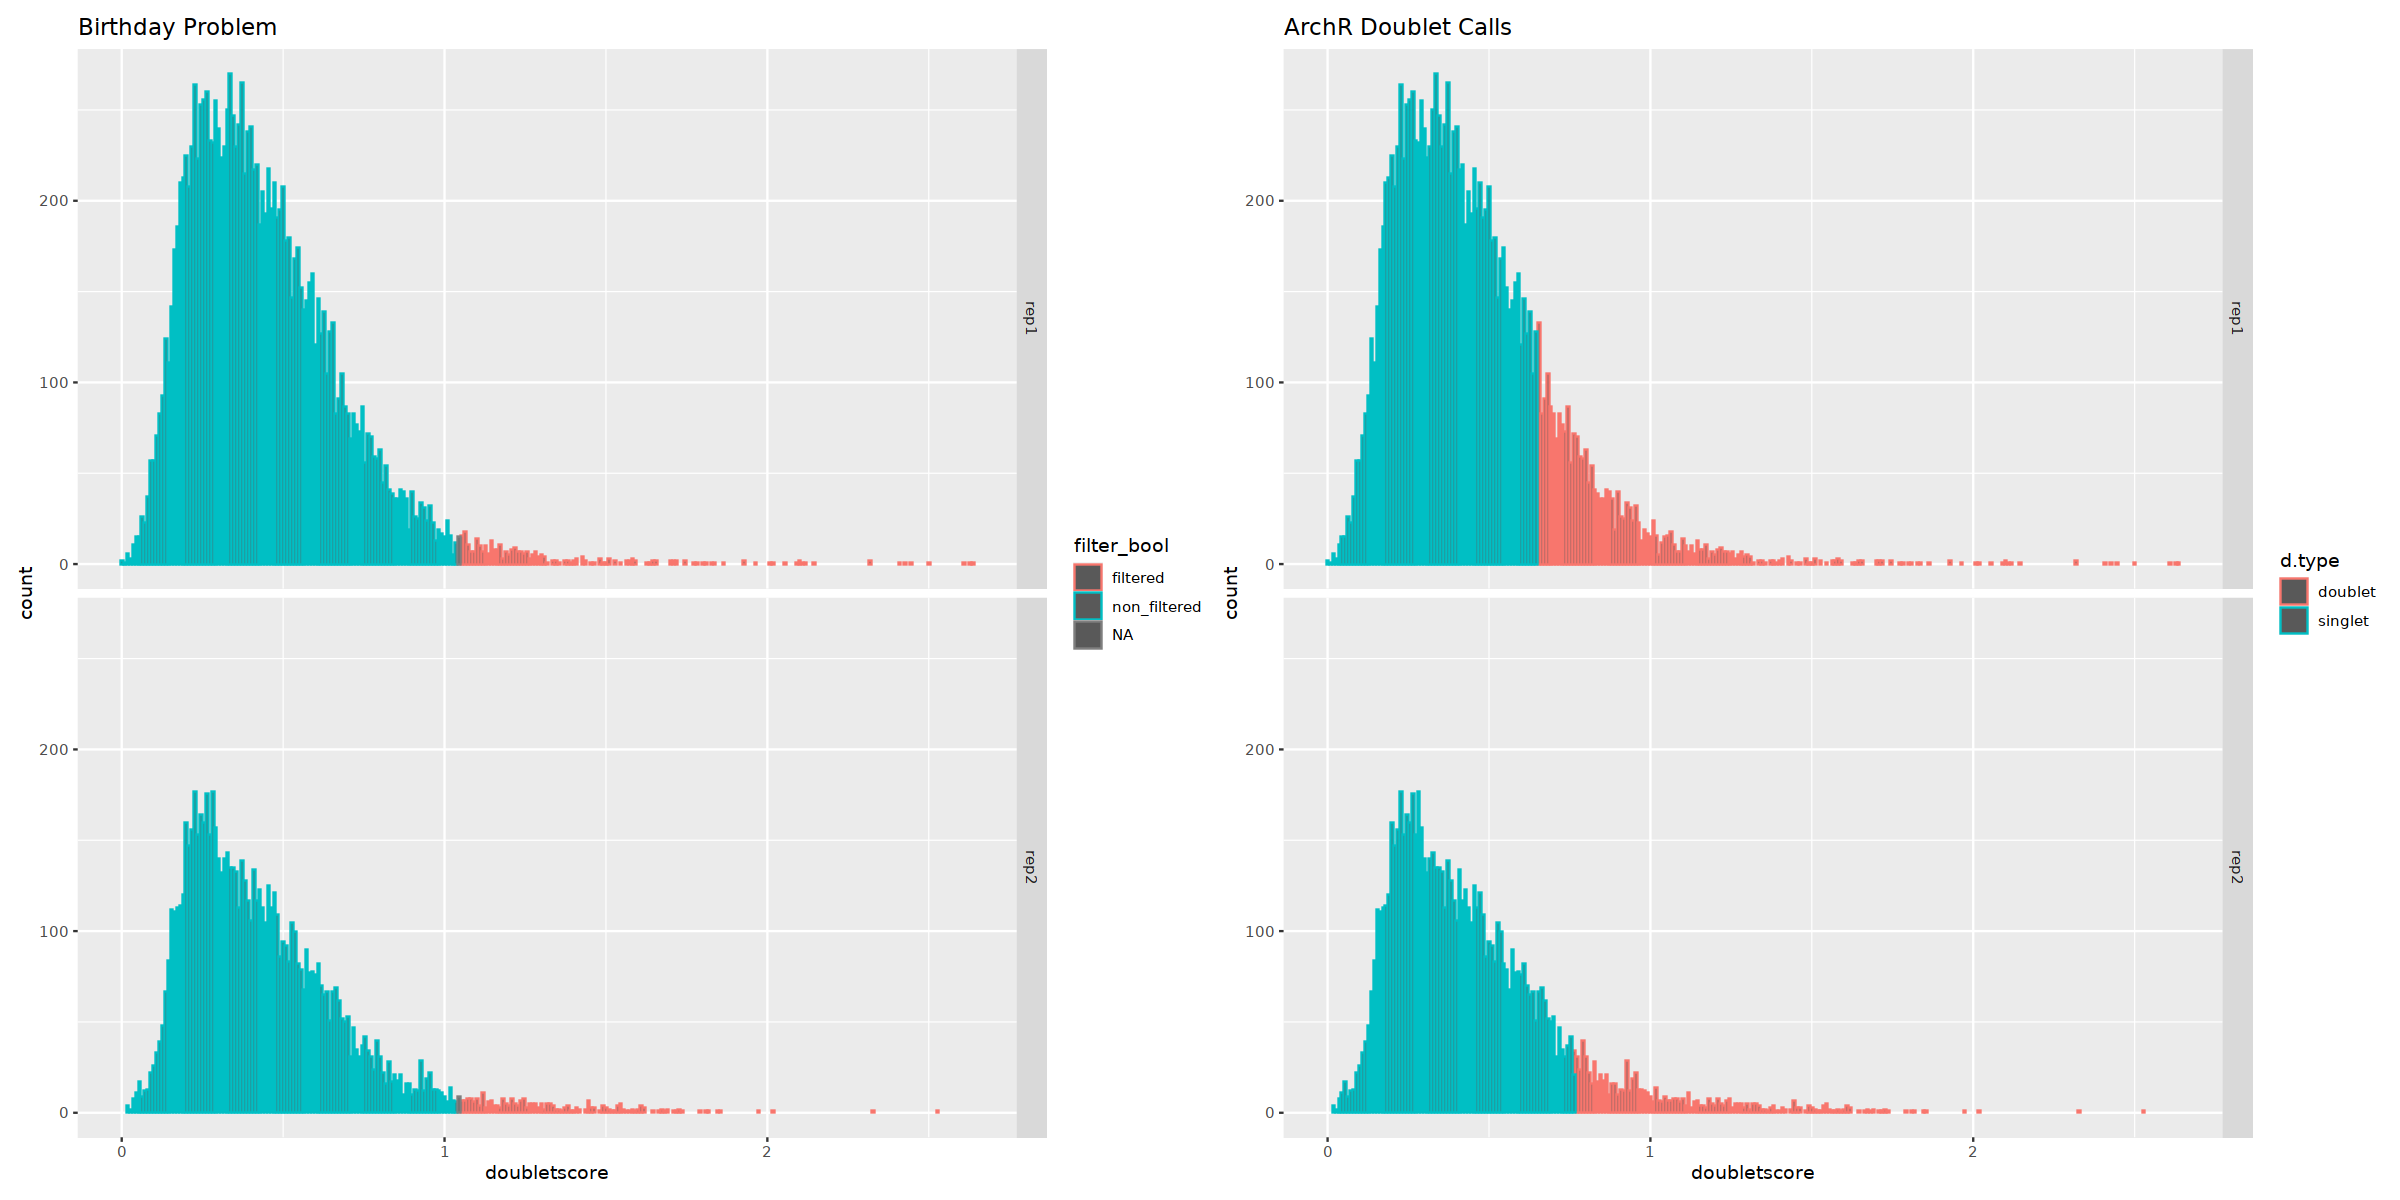

In [108]:
options(repr.plot.width=20, repr.plot.height=10)

birthday_problem_graph + archR_graph_1

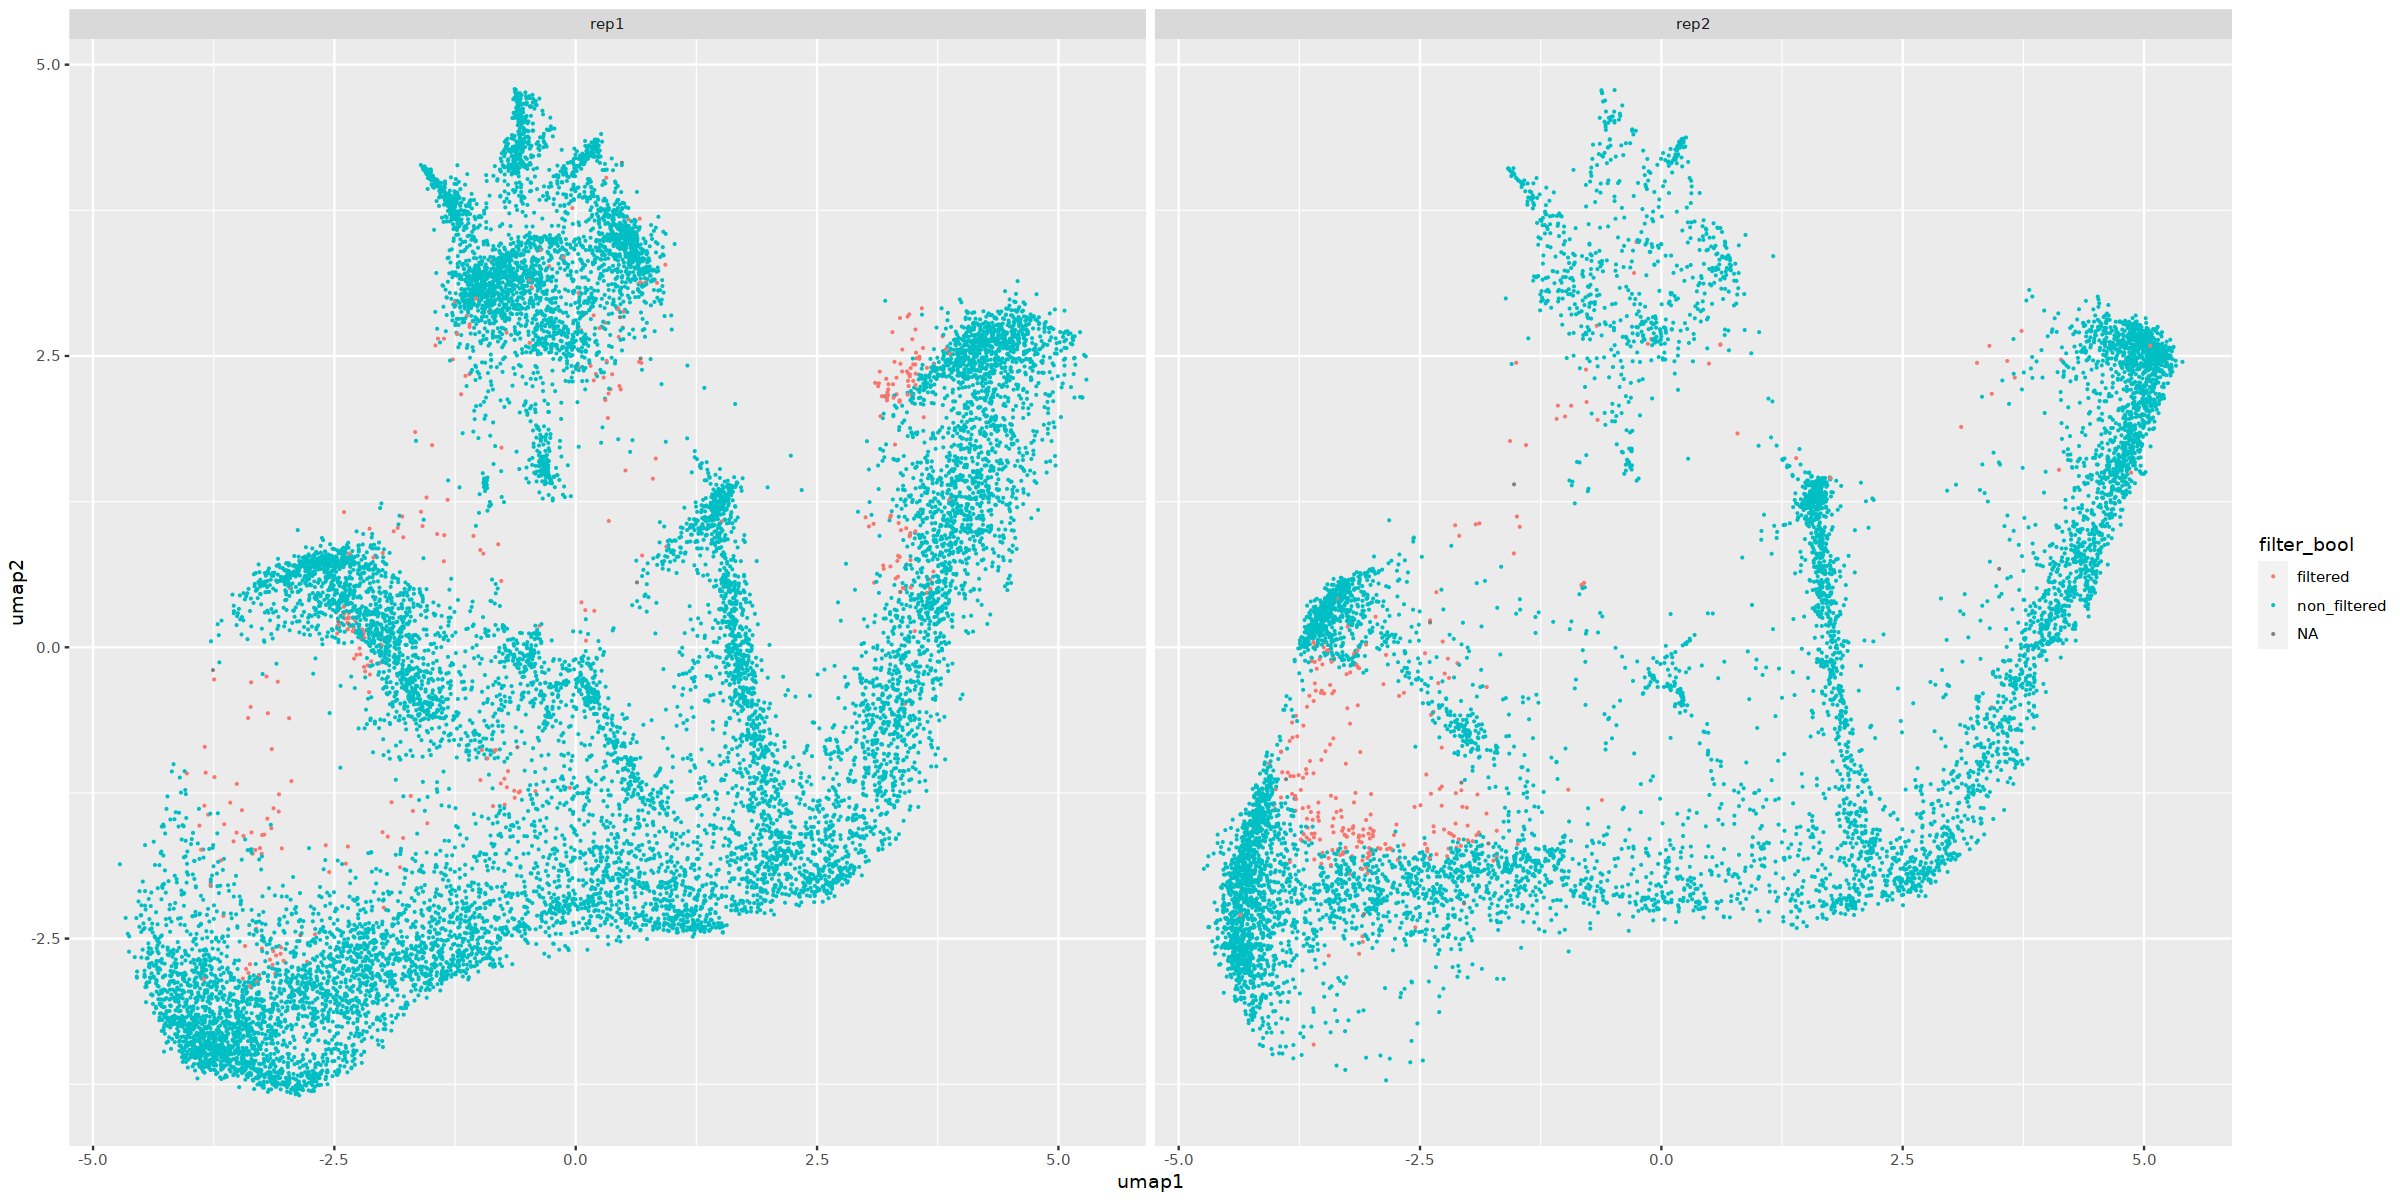

In [109]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(birthday_problem ,aes(umap1, umap2, color = filter_bool)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

In [110]:
tfidf.obj.dob.filt.removed <- remove_doublets(tfidf.obj.dob.filt)

   * Doublet filtering * Number cells removed= 3236  Filtered: cells = 19203 | peaks = 55443



 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18873
Number of edges: 1421281

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.7418
Number of communities: 22
Elapsed time: 45 seconds


1 singletons identified. 21 final clusters.

 - finished graph-based clustering ...

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 18644

 - filtering clusters with low cell/read counts ...



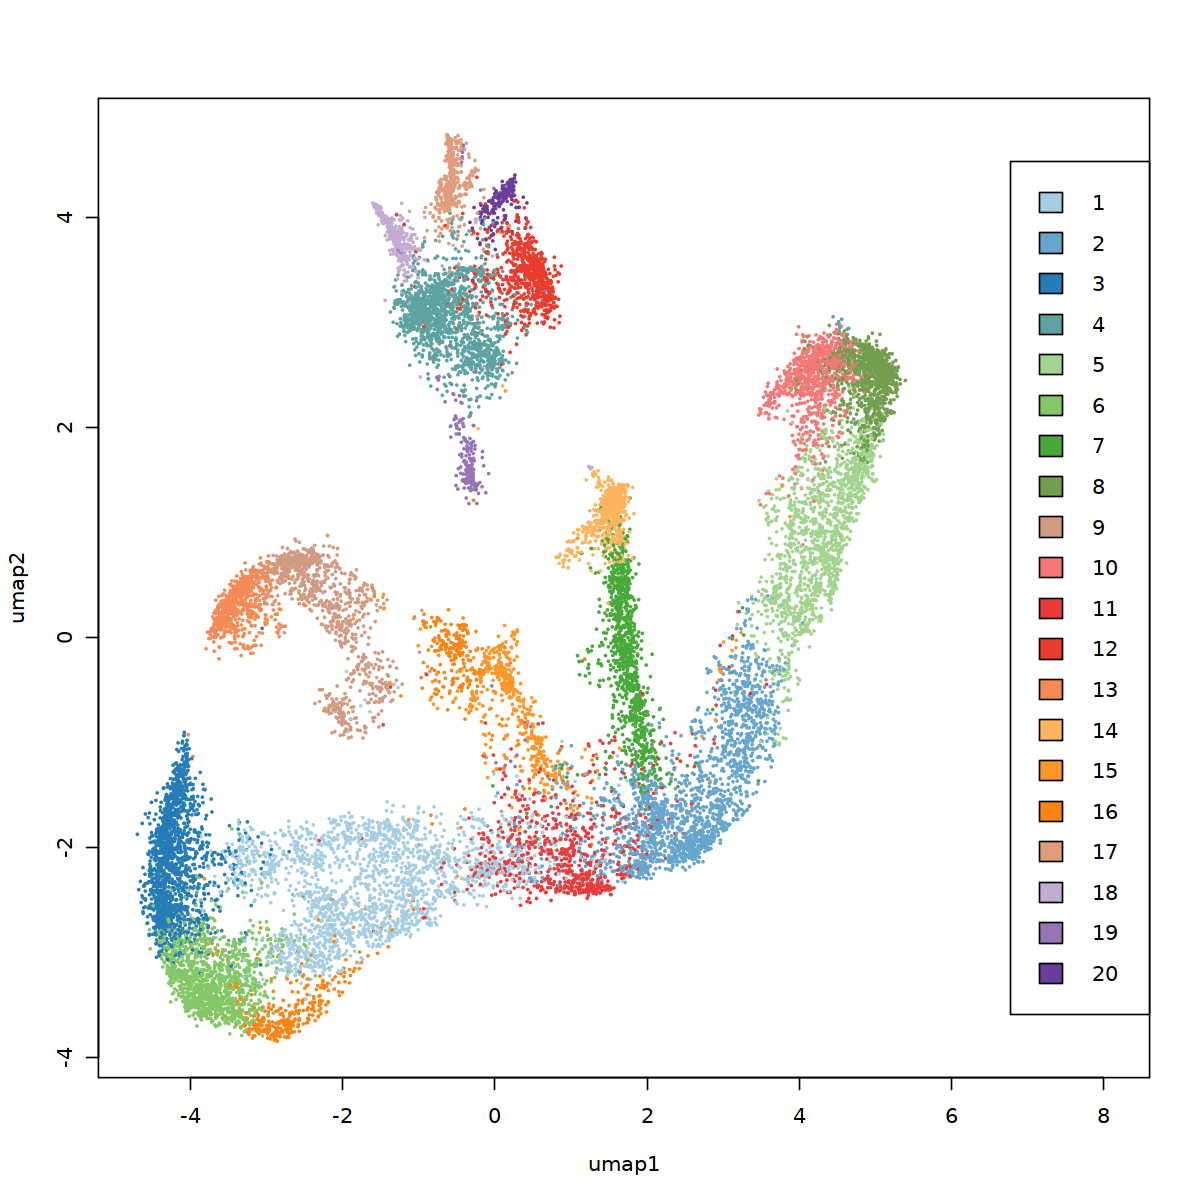

In [111]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt.removed, 
                        res=2,
                        verbose=T,
                        svd_slotName= "SVD",
                        cleanCluster=T)

#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
#pdf(paste0(out,".NMF.full.UMAP.clusters.pdf"), width=10, height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()



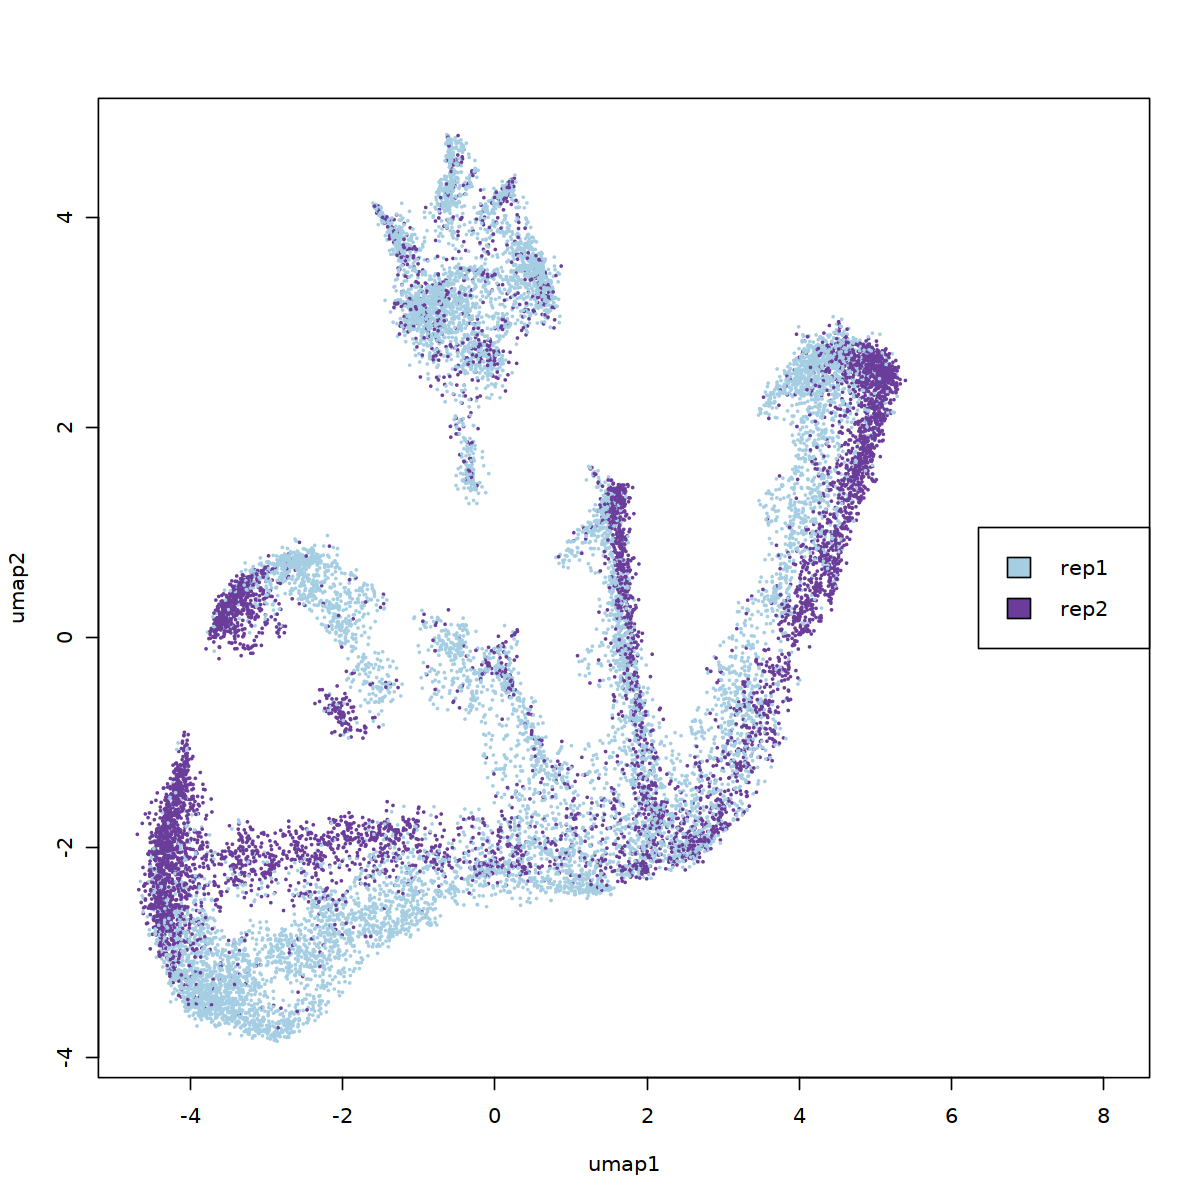

In [112]:
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3, column = "sampleID")

### Check Plate Integrations As well
If the replicates are so bad... Maybe some plates within the replicate are driving the issue?

In [113]:
library(tidyverse)
cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)  %>% 
    separate(col = "cellID", c("barcode", "plate"), sep = "-", remove = FALSE)
cell_converted_trible.df <- as.data.frame(cell_converted_trible)
colnames(cell_converted_trible)

[1] "cellID"          "barcode"         "plate"           "total"          
 [5] "tss"             "acrs"            "ptmt"            "nSites"         
 [9] "log10nSites"     "pTSS"            "FRiP"            "pOrg"           
[13] "tss_z"           "acr_z"           "sites_z"         "qc_check"       
[17] "background"      "cellbulk"        "is_cell"         "sampleID"       
[21] "umap1"           "umap2"           "doubletscore"    "d.type"         
[25] "LouvainClusters"

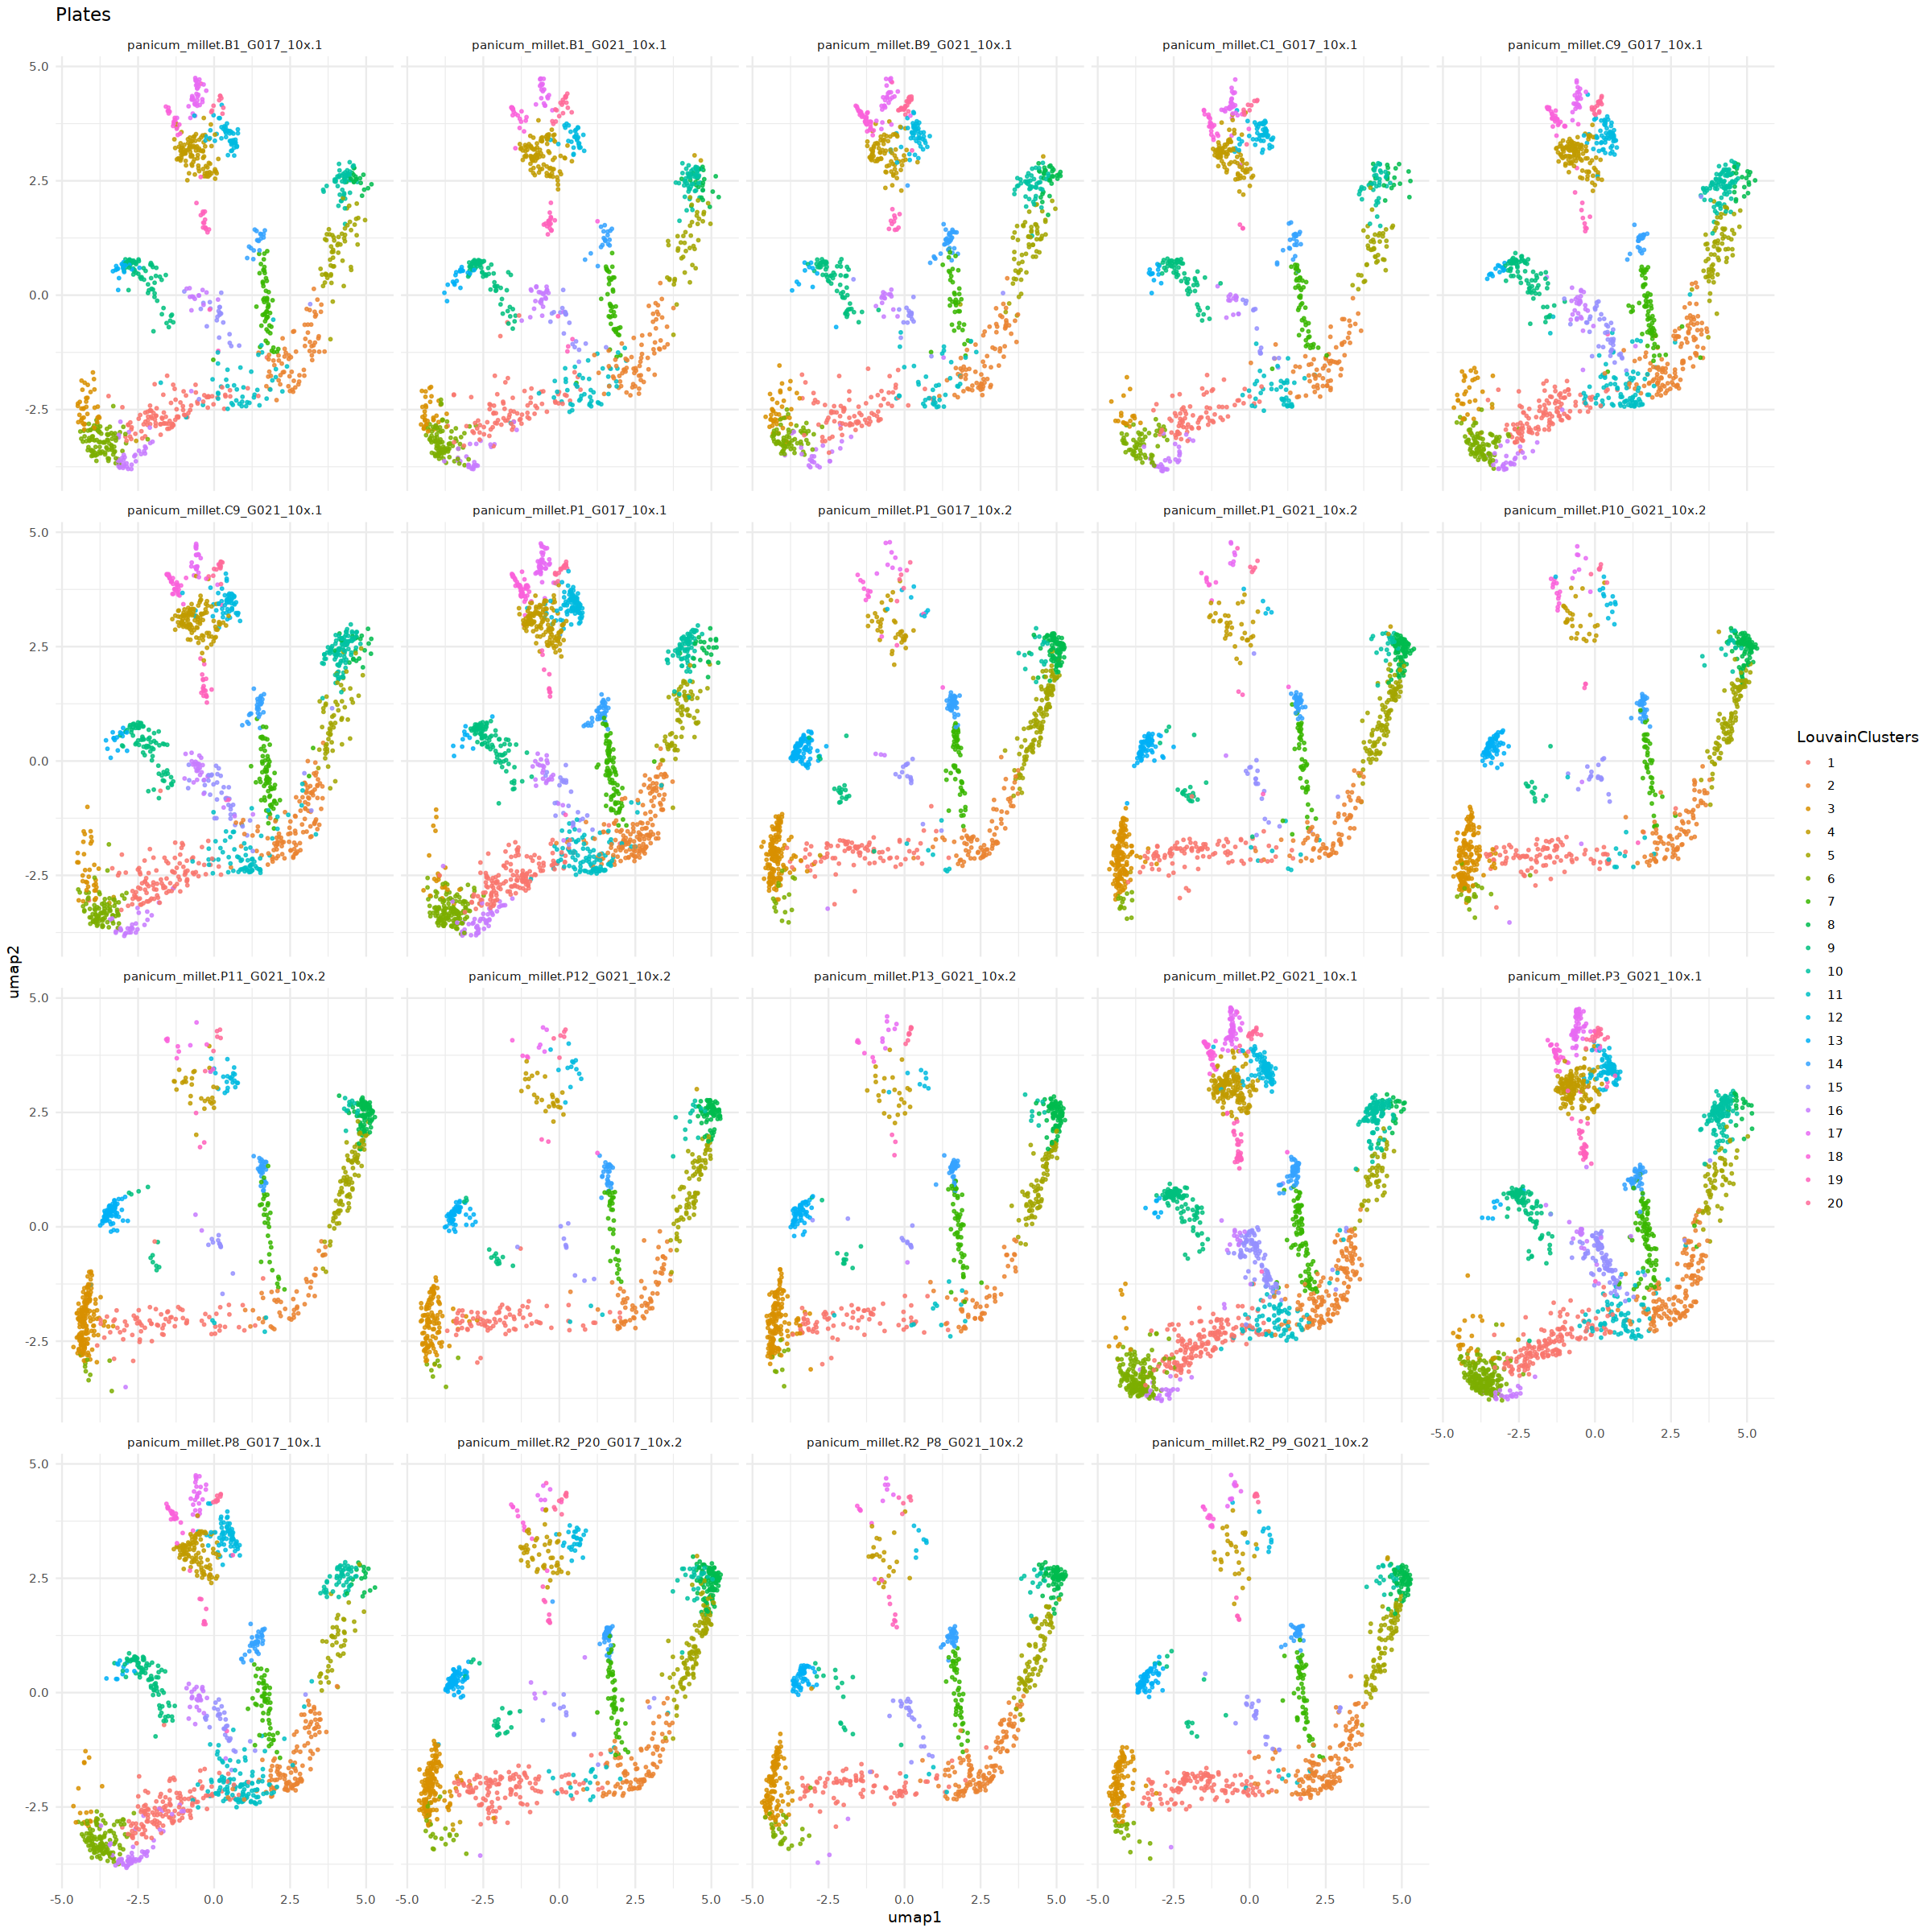

In [114]:
options(repr.plot.width=20, repr.plot.height=20)
ggplot(cell_converted_trible, aes(umap1, umap2, color = LouvainClusters)) + 
    geom_point(size = .6, alpha = .8) + theme_minimal() + ggtitle("Plates") +
    facet_wrap(~plate)

### Integration Looks Quite Poor 
Going to use harmony in order to improve overlap between the two datasets.

In [21]:
str(tfidf.obj.dob.filt.clusters$meta)

'data.frame':	19086 obs. of  22 variables:
 $ cellID      : chr  "BC:Z:TTAGGCCTTGTAGTATAATTCCTAACAT-panicum_millet.C9_G017_10x.1" "BC:Z:TTAGGCCTTGTAGTATAATTCCTAACAT-panicum_millet.C9_G021_10x.1" "BC:Z:CGATGTCCGTCCCTAAGACTGATACTAA-panicum_millet.C1_G017_10x.1" "BC:Z:ACTTGAGATCAGCATCTGAGTGGTGACC-panicum_millet.B9_G021_10x.1" ...
 $ total       : num  136093 108827 80910 76700 72611 ...
 $ tss         : num  15707 13013 31587 32433 31373 ...
 $ acrs        : num  18078 14879 60726 64560 61884 ...
 $ ptmt        : num  227 153 7162 98 836 ...
 $ nSites      : num  75808 61340 38444 35973 34017 ...
 $ log10nSites : num  4.88 4.79 4.58 4.56 4.53 ...
 $ pTSS        : num  0.115 0.12 0.39 0.423 0.432 ...
 $ FRiP        : num  0.133 0.137 0.751 0.842 0.852 ...
 $ pOrg        : num  0.00167 0.00141 0.08852 0.00128 0.01151 ...
 $ tss_z       : num  -0.783 -0.768 0.168 0.28 0.312 ...
 $ acr_z       : num  -1.794 -1.782 0.248 0.55 0.585 ...
 $ sites_z     : num  4.72 4.61 4.37 4.33 4.3 ...
 $ qc_ch

In [115]:
saved_cells <- cell_converted_trible$cellID
SVDs <- tfidf.obj.dob.filt.clusters$SVD
saved_SVDs <- SVDs[saved_cells, ]


saved_SVDs <- saved_SVDs[rowSums(saved_SVDs[])>0,]

fitlered_meta_passing_cells <- cell_converted_trible  %>% 
    dplyr::filter(cellID %in% rownames(saved_SVDs))  %>% 
    mutate(across(c(sampleID, 
                  plate),
                factor))

    

In [116]:
harmonized_pcs <- HarmonyMatrix(data_mat = saved_SVDs,       # Matrix with coordinates for each cell (row) along many PCs (columns)
  meta_data = fitlered_meta_passing_cells, # Dataframe with information for each cell (row)
  vars_use = c("sampleID"),
  verbose=TRUE, 
  theta = 2, ## cluster diversity enforcement
  nclust = 4, ## number of clusters in Harmony model  
  do_pca = FALSE      # Since we are providing PCs, do not run PCA
)

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations



In [140]:
tfidf.obj.dob.filt.clusters.replace_PCs <- tfidf.obj.dob.filt.clusters
tfidf.obj.dob.filt.clusters.replace_PCs$SVD <- harmonized_pcs


tfidf.obj.dob.filt.clusters.replace_PCs.umap <- projectUMAP(tfidf.obj.dob.filt.clusters.replace_PCs, 
                       verbose=T,
                       k.near=30,
                       m.dist=0.01,
                       svd_slotName="SVD")

# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters.replace_PCs.umap.clusters <- callClusters(tfidf.obj.dob.filt.clusters.replace_PCs.umap, 
                        res=1.5,
                        verbose=T,
                        svd_slotName= "SVD",                                                              
                        cleanCluster=FALSE)

 - non-linear dimensionality reduction with UMAP ...

12:14:01 UMAP embedding parameters a = 1.896 b = 0.8006

12:14:01 Read 9317 rows and found 30 numeric columns

12:14:01 Using Annoy for neighbor search, n_neighbors = 30

12:14:01 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:14:02 Writing NN index file to temp file /tmp/RtmpzzgKdz/file2800b5cdf1012

12:14:02 Searching Annoy index using 16 threads, search_k = 3000

12:14:02 Annoy recall = 100%

12:14:05 Commencing smooth kNN distance calibration using 16 threads
 with target n_neighbors = 30

12:14:08 Initializing from normalized Laplacian + noise (using irlba)

12:14:09 Commencing optimization for 500 epochs, with 465312 positive edges

12:14:50 Optimization finished

 - filtering outliers in UMAP manifold (z-

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9147
Number of edges: 785809

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.7461
Number of communities: 13
Elapsed time: 18 seconds


 - finished graph-based clustering ...

 - filtering clusters with low cell/read counts ...



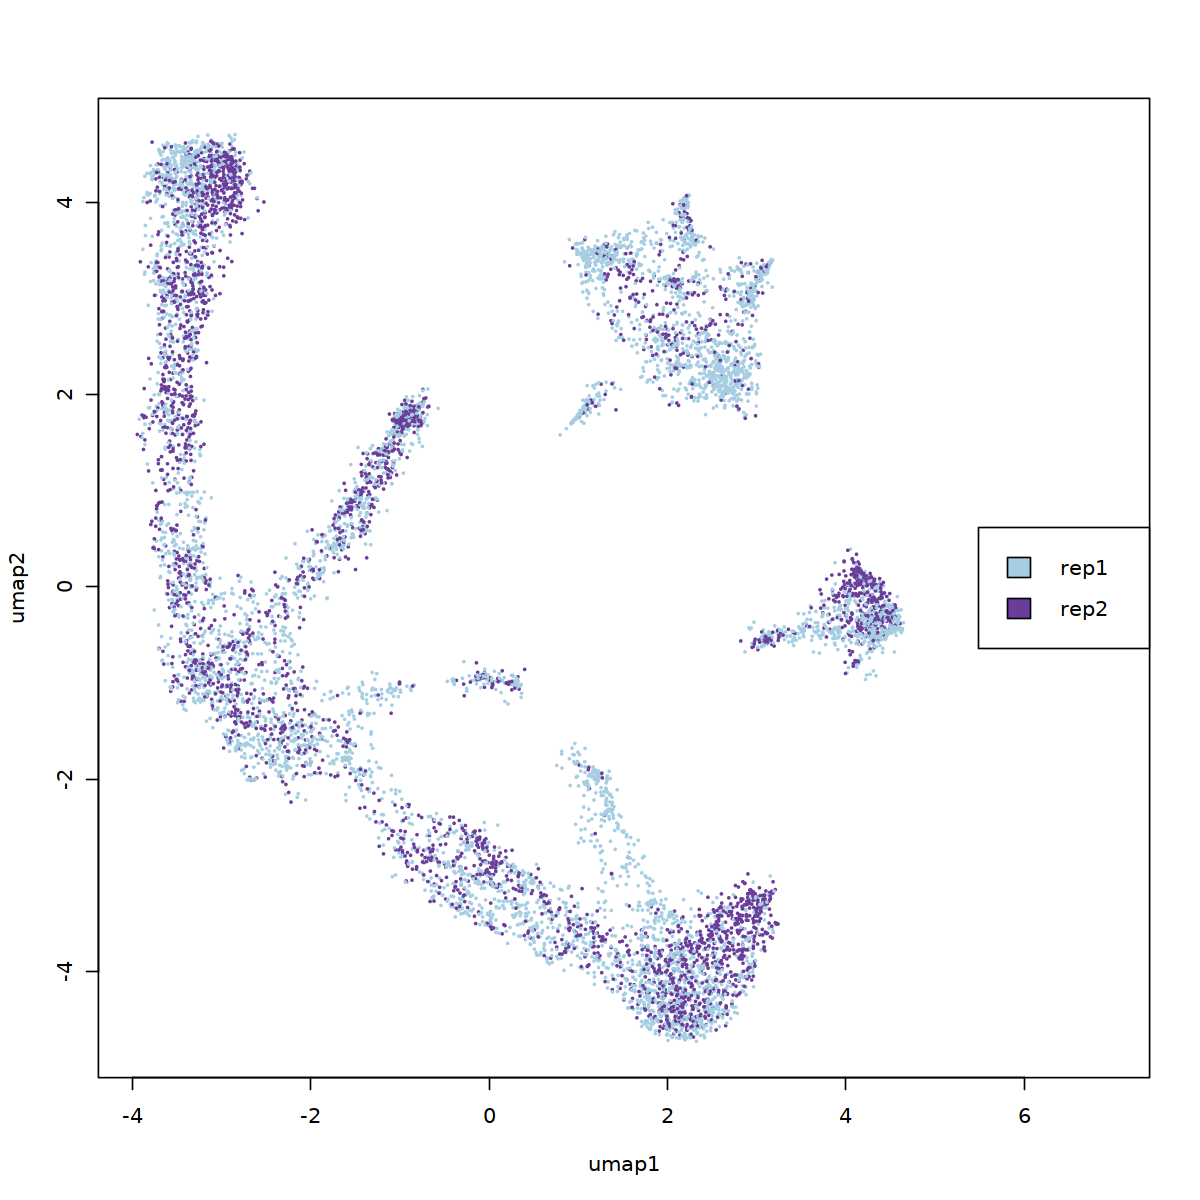

In [141]:
#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
# NMF
plotUMAP(tfidf.obj.dob.filt.clusters.replace_PCs.umap.clusters, cex=0.3, column = "sampleID")

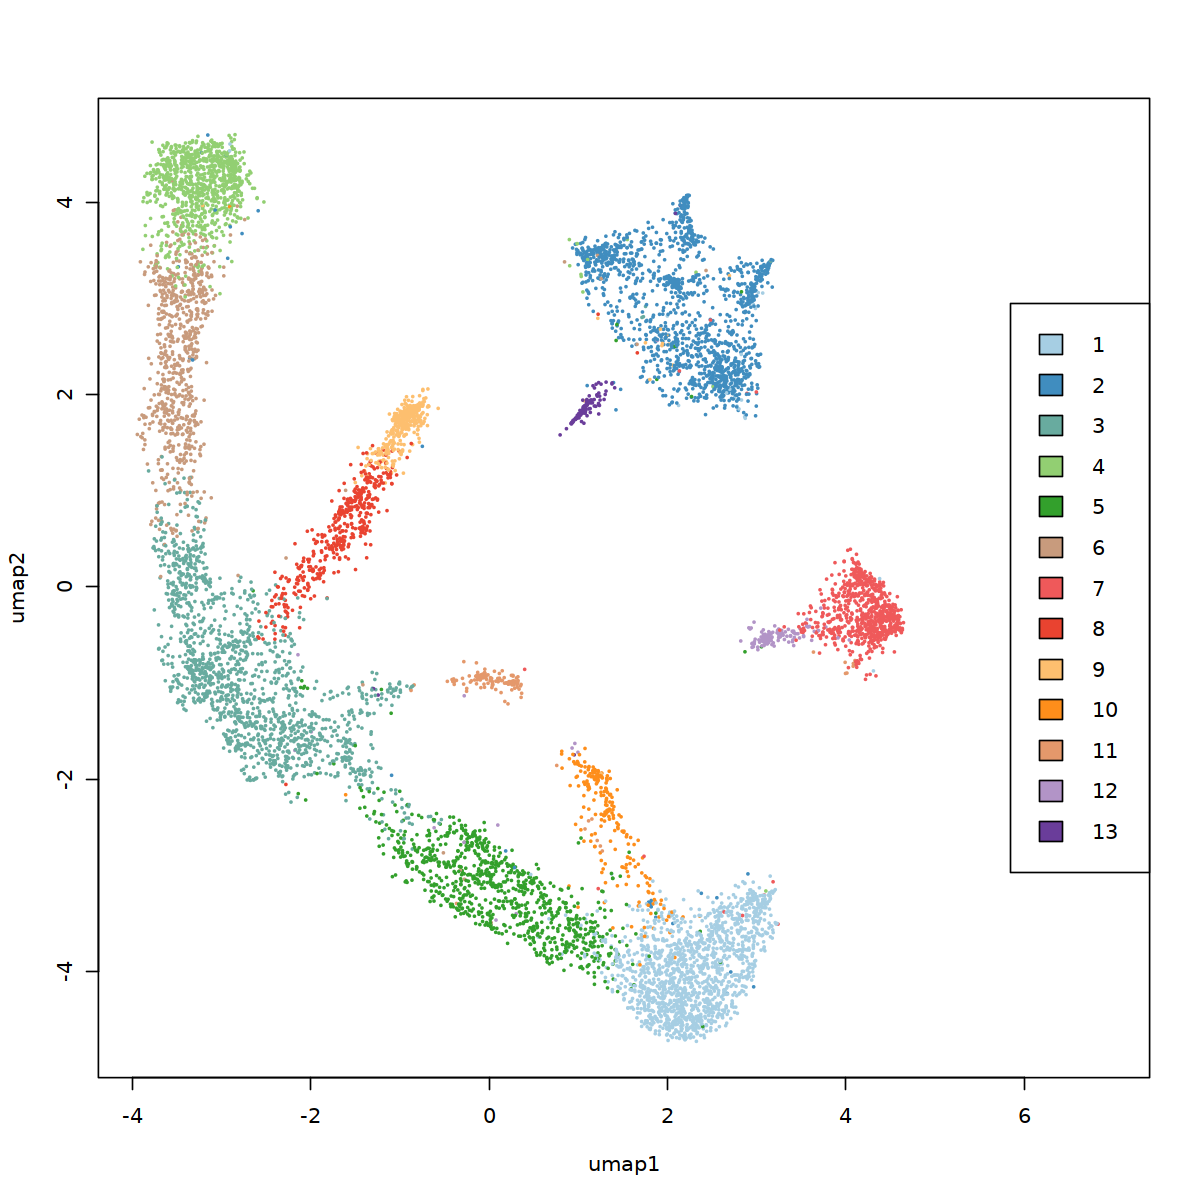

In [142]:
plotUMAP(tfidf.obj.dob.filt.clusters.replace_PCs.umap.clusters, cex=0.3)

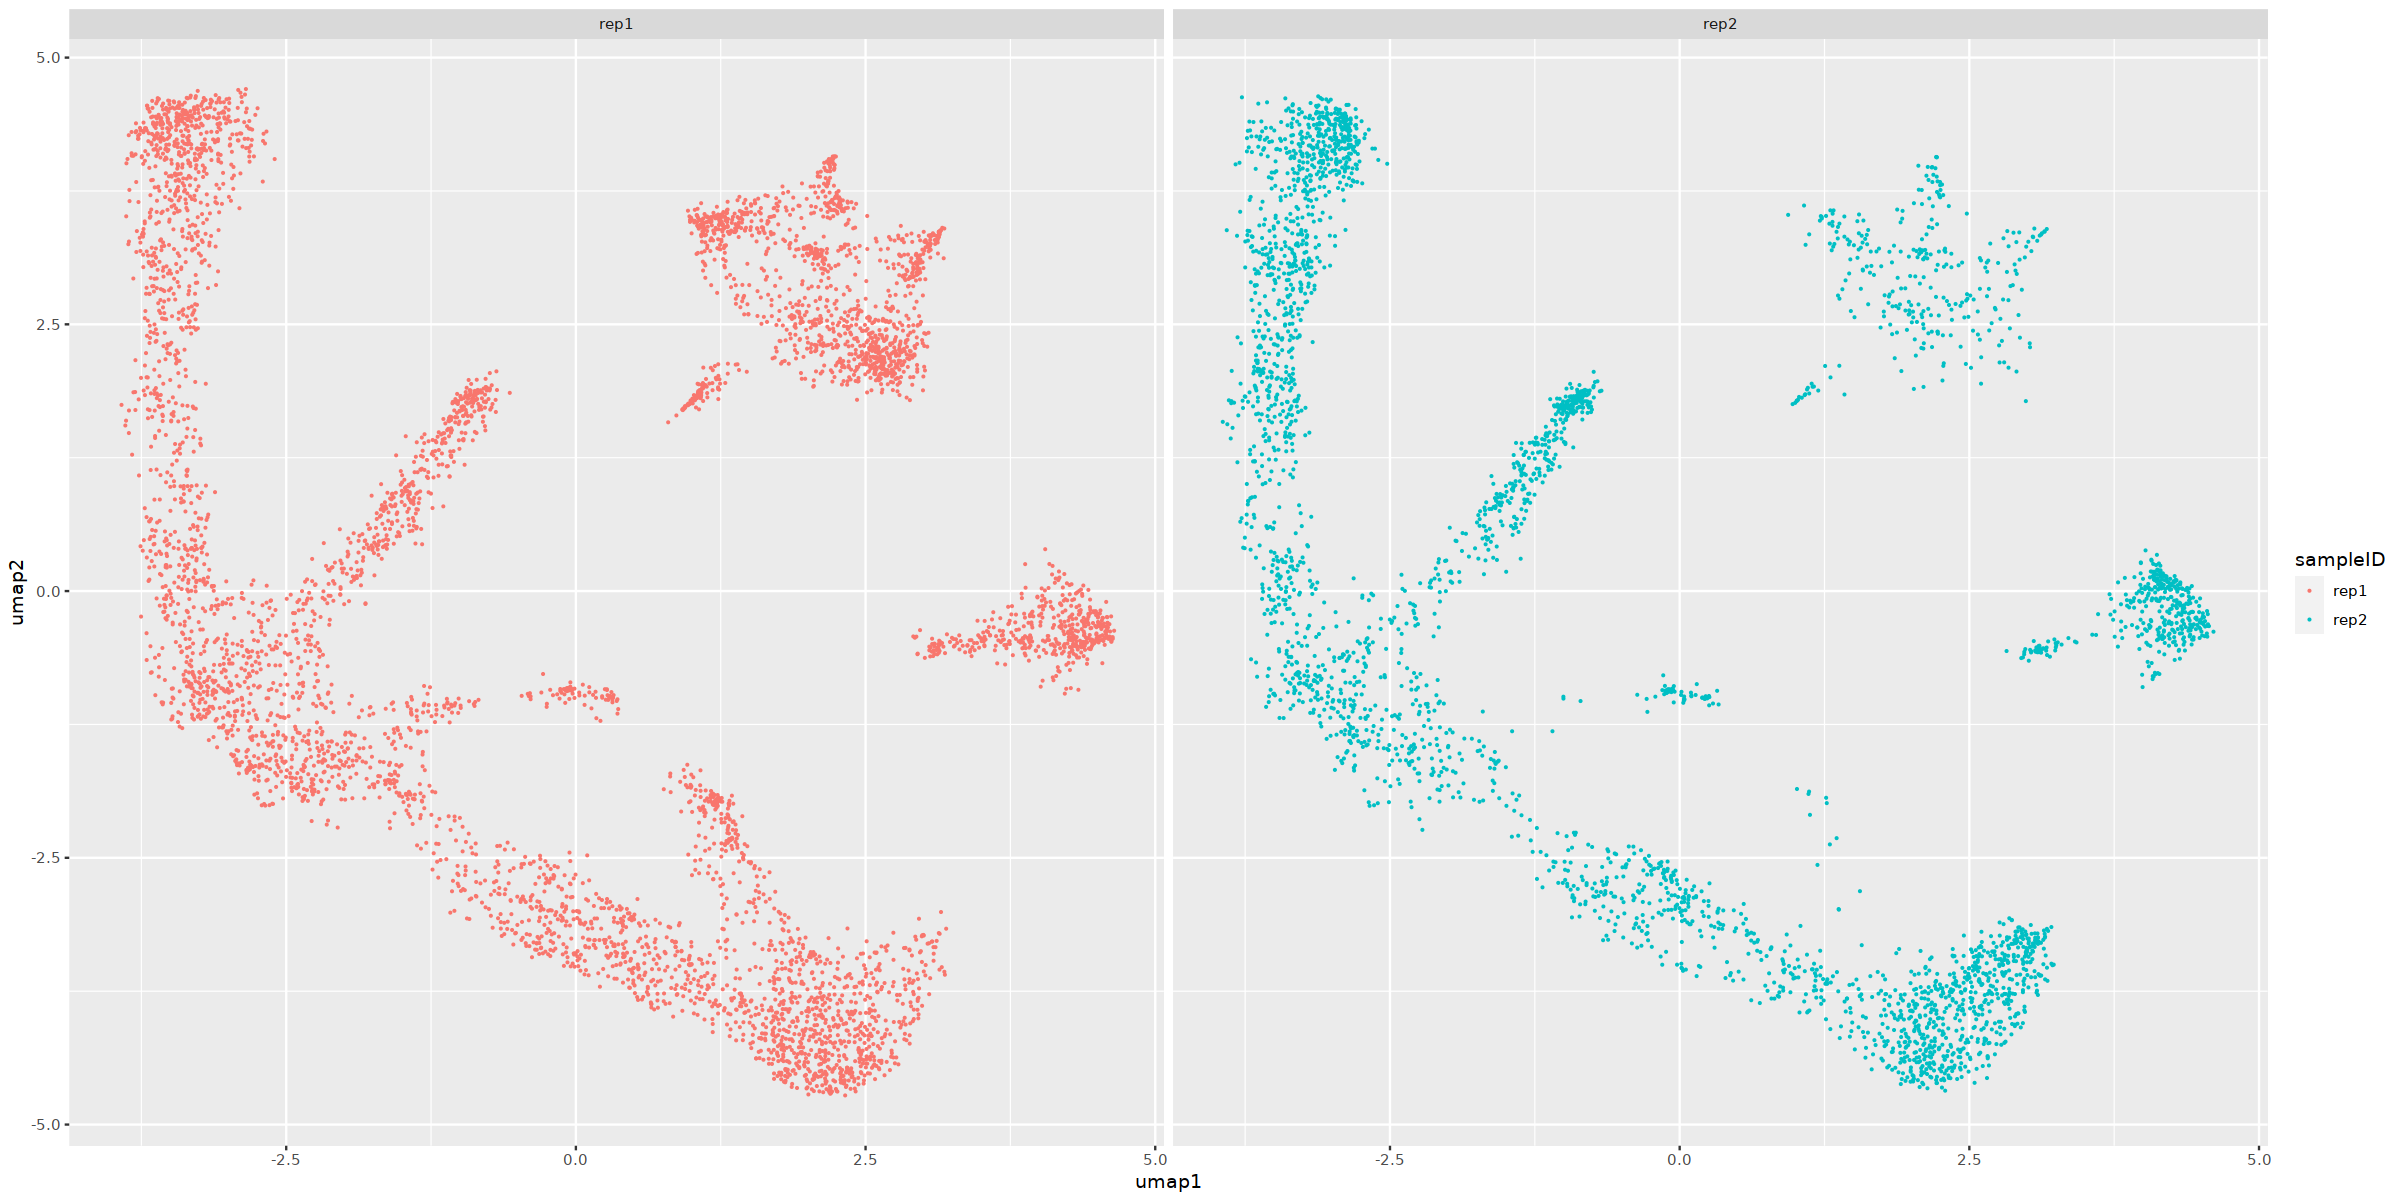

In [135]:
options(repr.plot.width=20, repr.plot.height=10)
cluster_plot <- as_tibble(tfidf.obj.dob.filt.clusters.replace_PCs.umap.clusters$Clusters)

ggplot(cluster_plot ,aes(umap1, umap2, color = sampleID)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

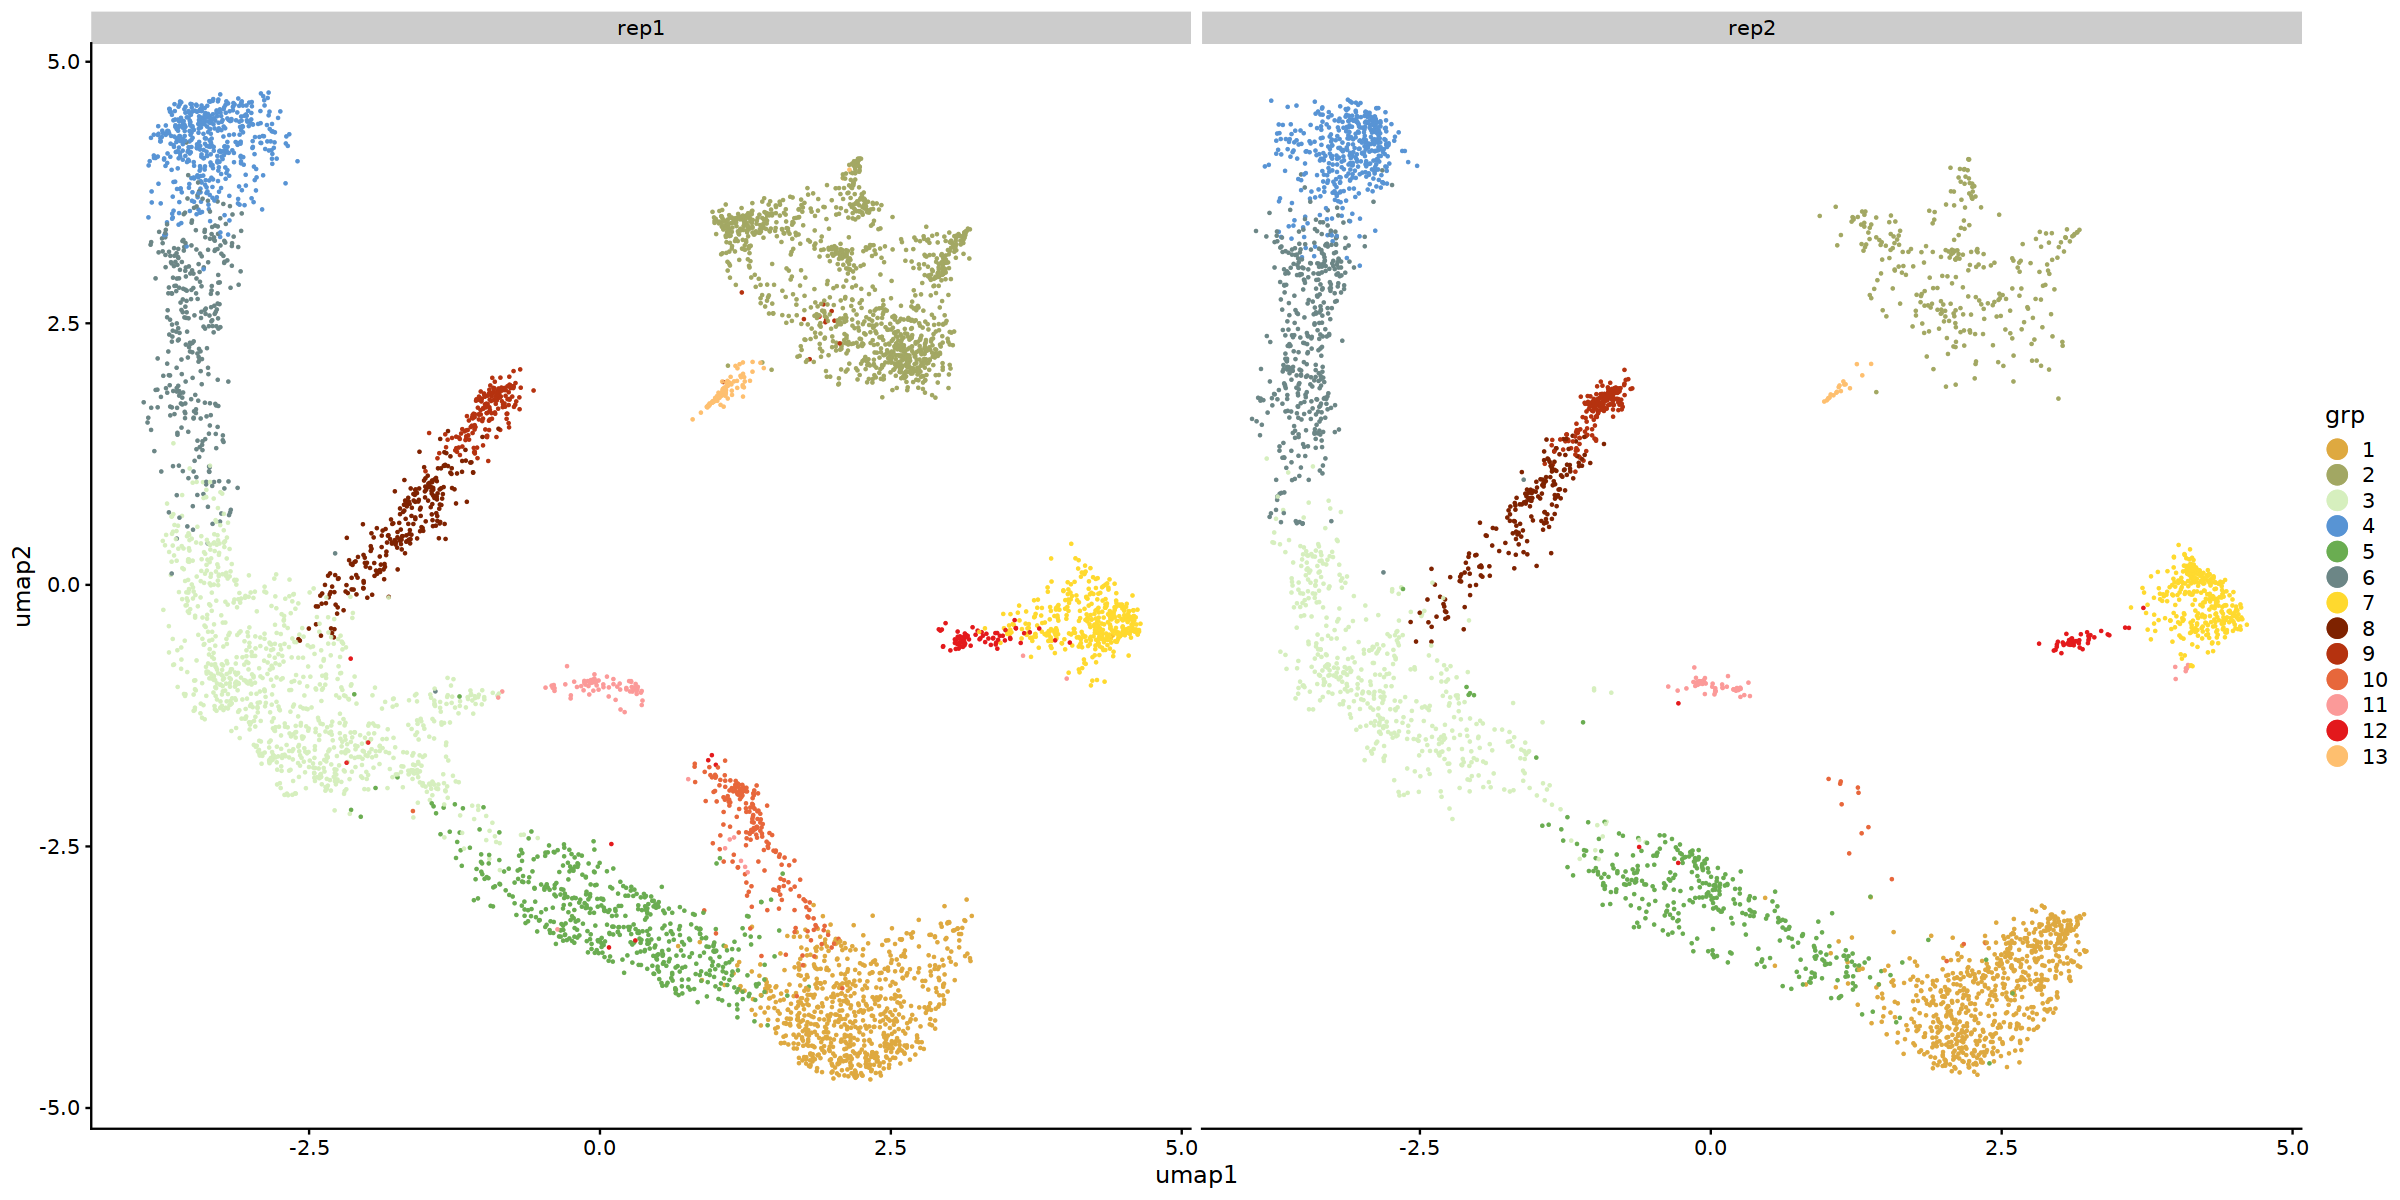

In [136]:
library(cowplot)
umap_cluster_colors <- c("#DEA940","#A2A763","#D6EEBE","#5894D4","#6AAD51","#6C8686","#FFD92F", "#7f2201","#b53310",
                         "#E7673B","#FB9A99","#E31A1C","#FDBF6F","#CAB2D6","#386CB0","#FFFFB3", "#5dead5","#c11577",
                         "#CCCCCC", "#7570B3","#B15928", "#6A3D9A", "#d87c6a", "#0060e8", "#84c5ff", "#ffd460", "#d81397")


col_scale <- scale_colour_manual(name = "grp", values = umap_cluster_colors)


options(repr.plot.width=20, repr.plot.height=10)
cluster_plot <- as_tibble(tfidf.obj.dob.filt.clusters.replace_PCs.umap.clusters$Clusters)

ggplot(cluster_plot ,aes(umap1, umap2, color = LouvainClusters)) + 
    col_scale + 
    geom_jitter(size = .1) + facet_grid(.~sampleID) + theme_half_open() +
    guides(colour = guide_legend(override.aes = list(size=5))) +
    geom_point(size = .25, alpha = .8)


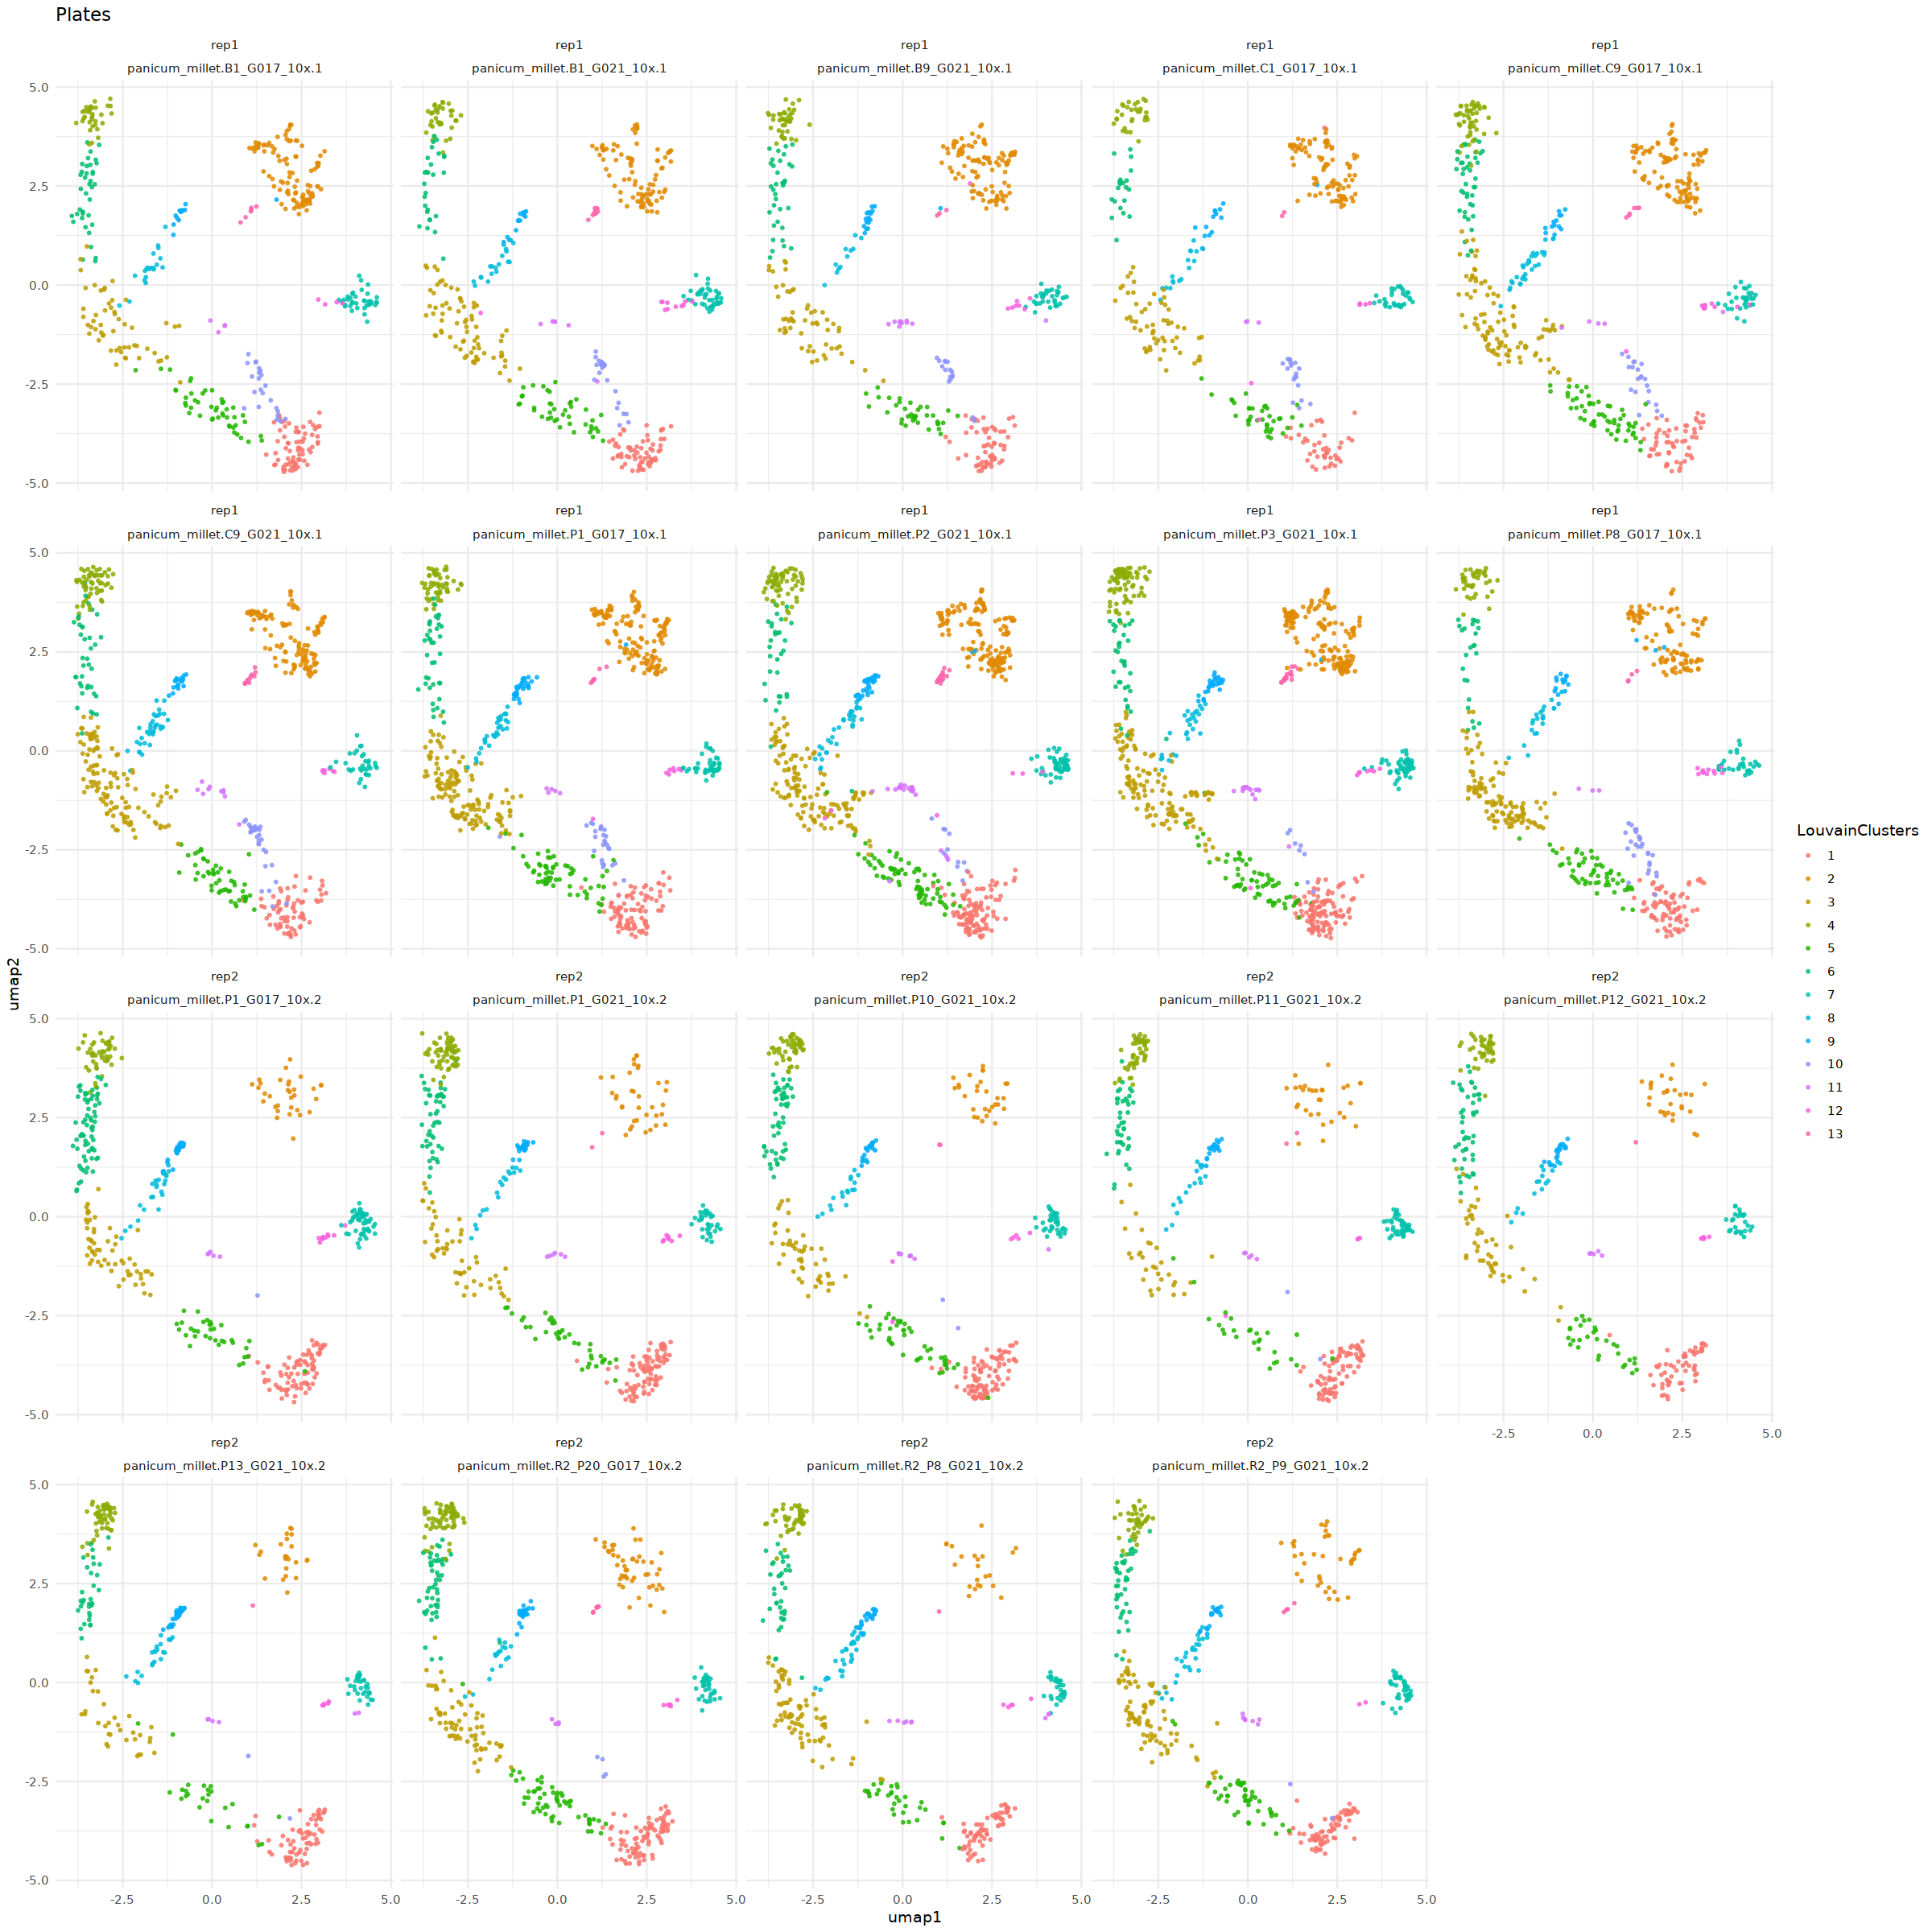

In [137]:
options(repr.plot.width=20, repr.plot.height=20)
cluster_plot  %>% 
    separate(col = "cellID", c("barcode", "plate"), sep = "-", remove = FALSE)  %>% 
    ggplot(., aes(umap1, umap2, color = LouvainClusters)) + 
    geom_point(size = .6, alpha = .8) + theme_minimal() + ggtitle("Plates") +
    facet_wrap(sampleID~plate)

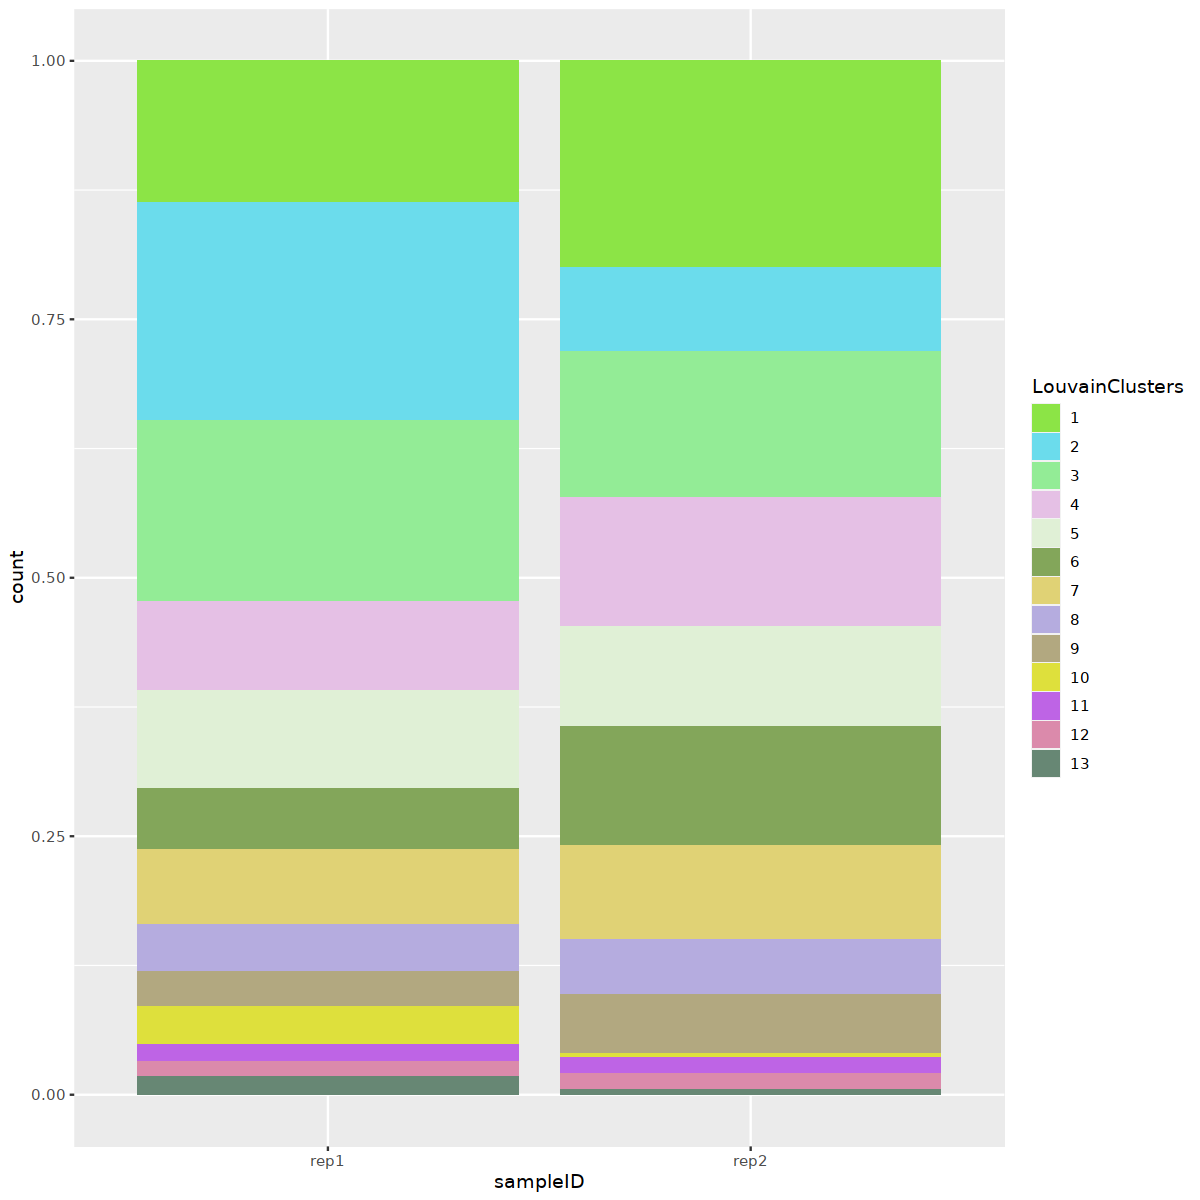

In [143]:

options(repr.plot.width=10, repr.plot.height=10)
library(RColorBrewer)
library(tidyverse)
other <- randomcoloR::distinctColorPalette(k = 41)
#cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)
ggplot(cluster_plot,aes(x = sampleID, fill = LouvainClusters)) + 
    geom_bar(position = "fill") + scale_fill_manual(values=other)


In [148]:
clusters_by_replicate <- cluster_plot  %>% 
    group_by(LouvainClusters, sampleID)  %>% 
    summarise(counts = n())

clusters_prop <- cluster_plot  %>% 
    group_by(LouvainClusters)  %>% 
    summarise(total_cluster = n())


clusters_full_joined <- full_join(clusters_by_replicate, clusters_prop, by = c("LouvainClusters"))  %>% 
    mutate(prop_cluster = counts/total_cluster)

clusters_full_joined

`summarise()` has grouped output by 'LouvainClusters'. You can override using the `.groups` argument.


LouvainClusters sampleID counts total_cluster prop_cluster
1  1               rep1      757   1464          0.51707650  
2  1               rep2      707   1464          0.48292350  
3  2               rep1     1159   1444          0.80263158  
4  2               rep2      285   1444          0.19736842  
5  3               rep1      962   1461          0.65845311  
6  3               rep2      499   1461          0.34154689  
7  4               rep1      475    917          0.51799346  
8  4               rep2      442    917          0.48200654  
9  5               rep1      524    865          0.60578035  
10 5               rep2      341    865          0.39421965  
11 6               rep1      327    734          0.44550409  
12 6               rep2      407    734          0.55449591  
13 7               rep1      398    721          0.55201110  
14 7               rep2      323    721          0.44798890  
15 8               rep1      247    434          0.56912442  
16 8               rep2      187    434          0.43087558  
17 9               rep1      188    389          0.48329049  
18 9               rep2      201    389          0.51670951  
19 10              rep1      202    215          0.93953488  
20 10              rep2       13    215          0.06046512  
21 11              rep1       92    147          0.62585034  
22 11              rep2       55    147          0.37414966  
23 12              rep1       79    133          0.59398496  
24 12              rep2       54    133          0.40601504  
25 13              rep1       98    117          0.83760684  
26 13              rep2       19    117          0.16239316

Warning message:
"Removed 206 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 206 rows containing non-finite values (`stat_boxplot()`)."


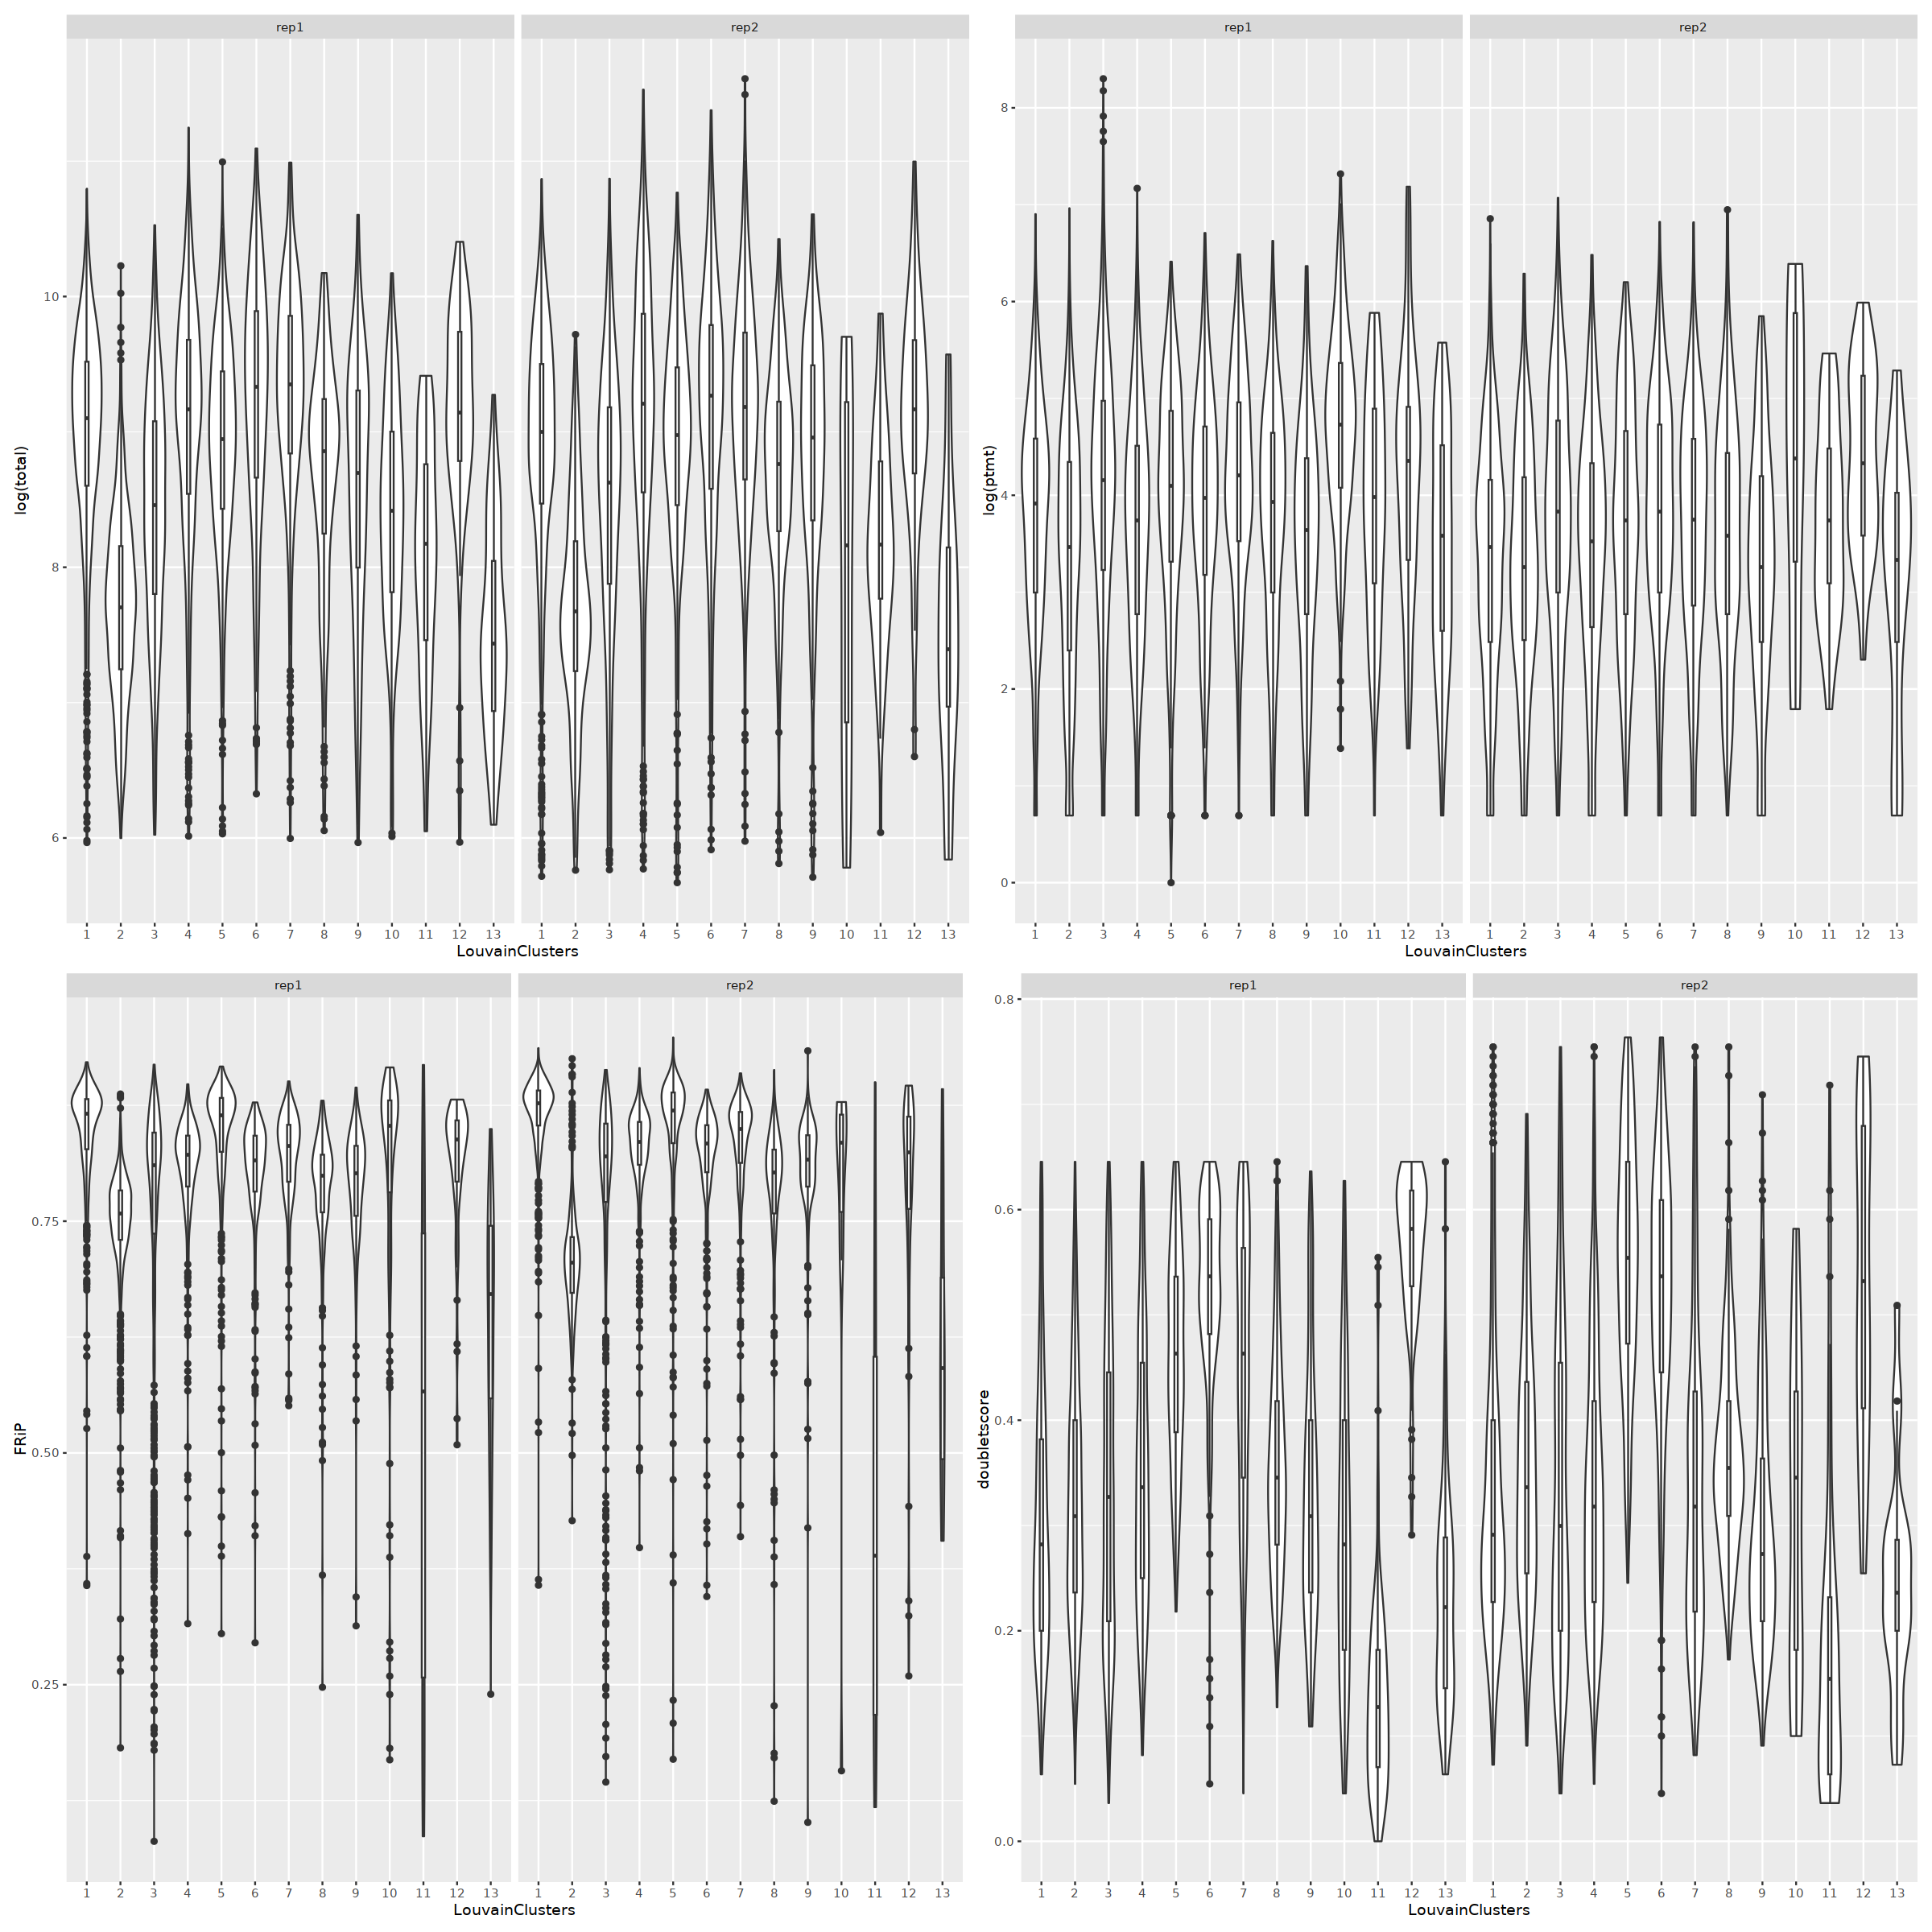

In [149]:
library(patchwork)

options(repr.plot.width=20, repr.plot.height=20)
total <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = log(total))) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)


ptmt <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = log(ptmt))) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)

tss <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = tss)) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)
 

frip <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = FRiP)) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)

doub <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = doubletscore)) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)

(total + ptmt) / (frip + doub)

In [150]:
clusters_passing <- cluster_plot  %>% 
    dplyr::filter(LouvainClusters != "13")  %>% 
    dplyr::filter(LouvainClusters != "10")

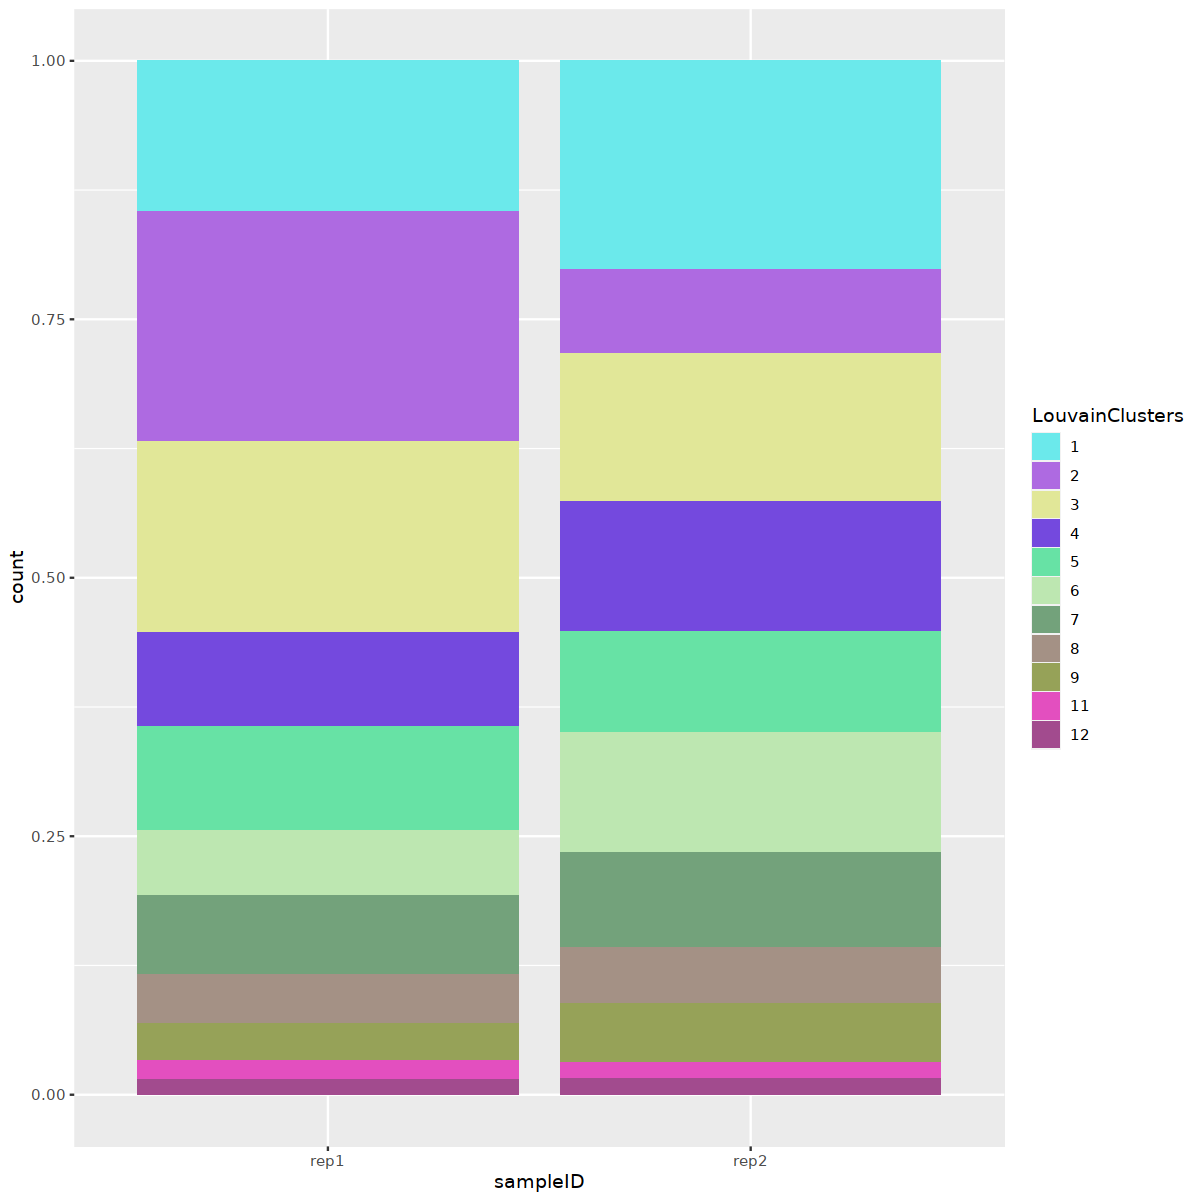

In [151]:

options(repr.plot.width=10, repr.plot.height=10)
library(RColorBrewer)
library(tidyverse)
other <- randomcoloR::distinctColorPalette(k = 41)
#cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)
ggplot(clusters_passing,aes(x = sampleID, fill = LouvainClusters)) + 
    geom_bar(position = "fill") + scale_fill_manual(values=other)


In [152]:
prefix <- "Pm_leaf.merged_replicates"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/proso_millet/clustering/"
#paste0(data_path, prefix,".merged_clusters.sparse")
# output text files
nmf.meta <- clusters_passing
nmf.rd <- tfidf.obj.dob.filt.clusters.replace_PCs.umap.clusters$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")

In [153]:
#Generate Sparse Matrix-
trip <- as.data.frame(summary(tfidf.obj.dob.filt.clusters.replace_PCs.umap.clusters$counts))
trip$i <- rownames(tfidf.obj.dob.filt.clusters.replace_PCs.umap.clusters$counts)[trip$i]
trip$j <- colnames(tfidf.obj.dob.filt.clusters.replace_PCs.umap.clusters$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")

# Running Presto and Cluster Correlation on LCs
## 3/27/2023

In [1]:
library("presto")
run_presto <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim='\t', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    print(head(loaded_sparse_matric))
    combined_large_w_sparse <- loaded_sparse_matric  %>% 
        filter(gene_name != "Annotation")  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))  %>% 
        filter(is.na(!!sym(cluster_name)) != TRUE)  %>% 
        arrange(!!sym(cluster_name))
    
    #order <- combined_large_w_sparse[!!sym(cluster_name)]

    combined_large_w_sparse <- combined_large_w_sparse  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        mutate(across(accessability, as.numeric))
    
    
    gene_names <- unique(combined_large_w_sparse$gene_name)
    barcodes <- unique(combined_large_w_sparse$barcode)

    combined_large_w_sparse$row <- match(combined_large_w_sparse$gene_name, gene_names)
    combined_large_w_sparse$col <- match(combined_large_w_sparse$barcode, barcodes)


    UIMatrix <- sparseMatrix(i = combined_large_w_sparse$row,
                         j = combined_large_w_sparse$col,
                         x = combined_large_w_sparse$accessability,
                         dimnames=list(gene_names, barcodes))

    print(head(tibble(barcode = unlist(UIMatrix@Dimnames[2]))))
    barcode_tibble <- tibble(barcode = unlist(UIMatrix@Dimnames[2])) %>% 
        left_join(., as_tibble(meta_data), by = c("barcode" = "cellID"))  %>% 
        filter(is.na(total) != TRUE)
    
    print(dim(barcode_tibble))
    print(dim(UIMatrix))
    
    clust_name <- c(cluster_name)
    garbbed_louv_order <- pull(barcode_tibble,!!sym(clust_name))

    sparse_matrix_test <- wilcoxauc(UIMatrix, garbbed_louv_order)
    
    meta_obj[["presto_marker"]] <- sparse_matrix_test
    
    return(meta_obj)
}

Loading required package: Rcpp

Loading required package: data.table



In [2]:
library("here")
library(devtools)
library(Seurat)

load_all('/home/jpm73279/Socrates')



# bed <- system.file("extdata", "test.tn5.bed.gz", package = "Socrates")
#ann <- system.file("extdata", "gencode.v19.annotation.gff3.gz", package = "Socrates")
#chr <- system.file("extdata", "hg19.txt", package = "Socrates")

reference_genome_path <- "/home/jpm73279/genome_downloads/Pmiliaceum/"
analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/panicum_millet.snake/02.bed_files/"

ann <- paste0(reference_genome_path,"Pmiliaceum.gff")
chr <- paste0(reference_genome_path,"pm_genmap_output.chrom.sizes")
Proso_millet <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/panicum_millet.snake/03.bed_files_merged/panicum_millet.filter.mpq_10.rmdup.unique.sorted.bed"

#Load Object
Proso_millet.leaf <- loadBEDandGenomeData(Proso_millet, ann, chr)


ℹ Loading Socrates
Warning message:
"replacing previous import 'scales::viridis_pal' by 'viridis::viridis_pal' when loading 'Socrates'"
Running pre-check on input files and executable paths ...

BED file path = /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/panicum_millet.snake/03.bed_files_merged/panicum_millet.filter.mpq_10.rmdup.unique.sorted.bed ... ok

GFF file path = /home/jpm73279/genome_downloads/Pmiliaceum/Pmiliaceum.gff ... ok

Chromosome sizes file path = /home/jpm73279/genome_downloads/Pmiliaceum/pm_genmap_output.chrom.sizes ... ok

Macs2 is installed .... ok

 - loading data (this may take obj while for big BED files) ...

 - finished loading data



In [3]:
library(tidyverse)
pm_meta_data <- read_delim("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/proso_millet/clustering/Pm_leaf.merged_replicates.SVD.full.metadata.txt", skip = 1,
                           col_names =  c("row_n",'cellID', 'total', 'tss', 'acrs', 'ptmt', 'nSites', 'log10nSites', 'pTSS', 'FRiP', 'pOrg', 'tss_z', 'acr_z', 'sites_z', 'qc_check', 'background', 'cellbulk', 'is_cell', 'sampleID', 'umap1', 'umap2', 'doubletscore', 'd.type', 'LouvainClusters'))
pm_gene_counts <- "/scratch/jpm73279/comparative_single_cell/04.marker_annotation/panicum_millet/acc_metrics_leaf/panicum_millet.gene_body_acc_leaf.counts.txt" 

Proso_millet.leaf$meta <- pm_meta_data
Proso_millet.leaf$acr_counts_raw <- pm_gene_counts

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0.9000 ──
✔ dplyr     1.1.1          ✔ readr     2.1.4     
✔ forcats   1.0.0.9000     ✔ stringr   1.5.0     
✔ lubridate 1.9.2          ✔ tibble    3.2.1     
✔ purrr     1.0.1          ✔ tidyr     1.3.0     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ purrr::accumulate()   masks foreach::accumulate()
✖ readr::col_factor()   masks Socrates::col_factor(), scales::col_factor()
✖ dplyr::collapse()     masks IRanges::collapse()
✖ dplyr::combine()      masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()        masks matrixStats::count()
✖ dplyr::desc()         masks IRanges::desc()
✖ purrr::discard()      masks Socrates::discard(), scales::discard()
✖ tidyr::expand()       mas

In [4]:
pm_meta_data$row_n <- pm_meta_data$cellID

In [5]:
library(presto)
Proso_millet.leaf.presto <- run_presto(Proso_millet.leaf,
           meta_slot = "meta",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

Loading required package: data.table


Attaching package: 'data.table'


The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose


The following object is masked from 'package:slam':

    rollup


The following object is masked from 'package:GenomicRanges':

    shift


The following object is masked from 'package:IRanges':

    shift


The following objects are masked from 'package:S4Vectors':

    first, second




ERROR: Error in run_presto(Proso_millet.leaf, meta_slot = "meta", counts_raw = "acr_counts_raw", : could not find function "run_presto"


In [ ]:
marker_list_pm_file <- "/home/jpm73279/genome_downloads/Pmiliaceum/markers/Pm.final_all_markers.visualize.txt"
marker_list_pm <- read_delim(marker_list_pm_file, delim='\t', 
                                       col_names = c("chr", "start", "stop", "geneID", "gene_name", "cell_type", "tissue"))

In [ ]:
head(marker_list_pm)

In [ ]:
head(marker_list_pm)

In [ ]:
grabbed_top_marker_per_cluster <- top_markers(Proso_millet.leaf.presto$presto_marker, 200)

represented_marker_lst <- list()
for (i in unique(Proso_millet.leaf.presto$meta$LouvainClusters)) {
    
    #make_set <- setNames("geneID",i) 
    
    LC_top_genes <- grabbed_top_marker_per_cluster[, c("rank", i)]
    LC_top_genes <- dplyr::rename(LC_top_genes, geneID = as.character(i))
    
    markers_present_in_presto <- left_join(LC_top_genes, 
                                           marker_list_pm, by = c("geneID"))  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, geneID, chr, start, stop, gene_name, cell_type, tissue) %>% 
    dplyr::mutate(LC_value = str_c("LC", as.character(i),  sep ="_")) 
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

In [ ]:
gathered_markers <- bind_rows(represented_marker_lst)  %>% 
    arrange(LC_value, rank)

gathered_markers

In [96]:
library(edgeR)
library(preprocessCore)
devtools::load_all('/home/jpm73279/software/preprocessCore')
library("edgeR")

marker_correlation <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
   
    
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    
    raw_cpm_counts_all_genes <- read_delim(sparse_matrix, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
        dplyr::mutate(cellID = barcode)  %>%
        dplyr::mutate(geneID = gene_name)

    merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
        group_by(!!sym(cluster_name), geneID)  %>%
        summarise(counts = sum(accessability, na.rm = TRUE))

    ### Alt CPM Calc
    merged_meta_cpm_information_copied <- merged_meta_cpm_information
    catch <- merged_meta_cpm_information_copied  %>%
        group_by(!!sym(cluster_name)) %>%
        group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
        unlist()


    caught_values <- as_tibble(catch)

    see <- ungroup(merged_meta_cpm_information_copied)
    idk <- bind_cols(merged_meta_cpm_information_copied,caught_values)  
    print(head(idk))
    
    merged_meta_cpm_information_copied<- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
        ungroup()  %>% 
        dplyr::rename(grouped_CPM = value)  %>% 
        dplyr::group_by(!!sym(cluster_name)) %>%  
        dplyr::mutate(log_cpm  = log(grouped_CPM))


    #Apply quantile normalization
    merged_meta.quant_norm <- merged_meta_cpm_information_copied  %>% 
        group_by(!!sym(cluster_name))  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

    zm.quantile_normalized <- as_tibble(merged_meta.quant_norm)  %>% 
        dplyr::rename("quant_norm_cpm" = value)


    merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied, zm.quantile_normalized)

    cell_type_accessability <- merged_meta_cpm_information_copied  %>% 
        dplyr::ungroup()  %>% 
        dplyr::select(!!sym(cluster_name), geneID, quant_norm_cpm)  %>% 
        pivot_wider(names_from = !!sym(cluster_name), values_from = quant_norm_cpm, values_fill = 0)
    
    meta_obj[["corr_matrix"]] <- cell_type_accessability
    
    return(meta_obj)
}


ℹ Loading preprocessCore


# A tibble: 6 × 24
  row_n cellID    total   tss  acrs  ptmt nSites log10nSites  pTSS  FRiP    pOrg
  <dbl> <chr>     <dbl> <dbl> <dbl> <dbl>  <dbl>       <dbl> <dbl> <dbl>   <dbl>
1     1 BC:Z:ACT… 76700 32433 64560    98  35806        4.55 0.423 0.842 0.00128
2     2 BC:Z:TTA… 76268 31057 62696  1298  35463        4.55 0.407 0.822 0.0170 
3     3 BC:Z:TGA… 65729 26976 52271   264  32543        4.51 0.410 0.795 0.00402
4     4 BC:Z:CGA… 61579 25468 50773   231  29955        4.48 0.414 0.825 0.00375
5     5 BC:Z:CGA… 59528 23978 44841   334  29852        4.47 0.403 0.753 0.00561
6     6 BC:Z:TGA… 59510 25424 49537   175  29049        4.46 0.427 0.832 0.00294
# ℹ 13 more variables: tss_z <dbl>, acr_z <dbl>, sites_z <dbl>, qc_check <dbl>,
#   background <dbl>, cellbulk <dbl>, is_cell <dbl>, sampleID <chr>,
#   umap1 <dbl>, umap2 <dbl>, doubletscore <dbl>, d.type <chr>,
#   LouvainClusters <dbl>


Rows: 54642541 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'LouvainClusters'. You can override using the `.groups` argument.


# A tibble: 6 × 4
# Groups:   LouvainClusters [1]
  LouvainClusters geneID          counts  value
            <dbl> <chr>            <dbl>  <dbl>
1               1 C2845_PMCG10002   2426 318.  
2               1 C2845_PMCG10004    191  25.0 
3               1 C2845_PMCG10007     28   3.67
4               1 C2845_PMCG10009    110  14.4 
5               1 C2845_PMCG10011    274  35.9 
6               1 C2845_PMCG10012    276  36.2 


Selecting by resid


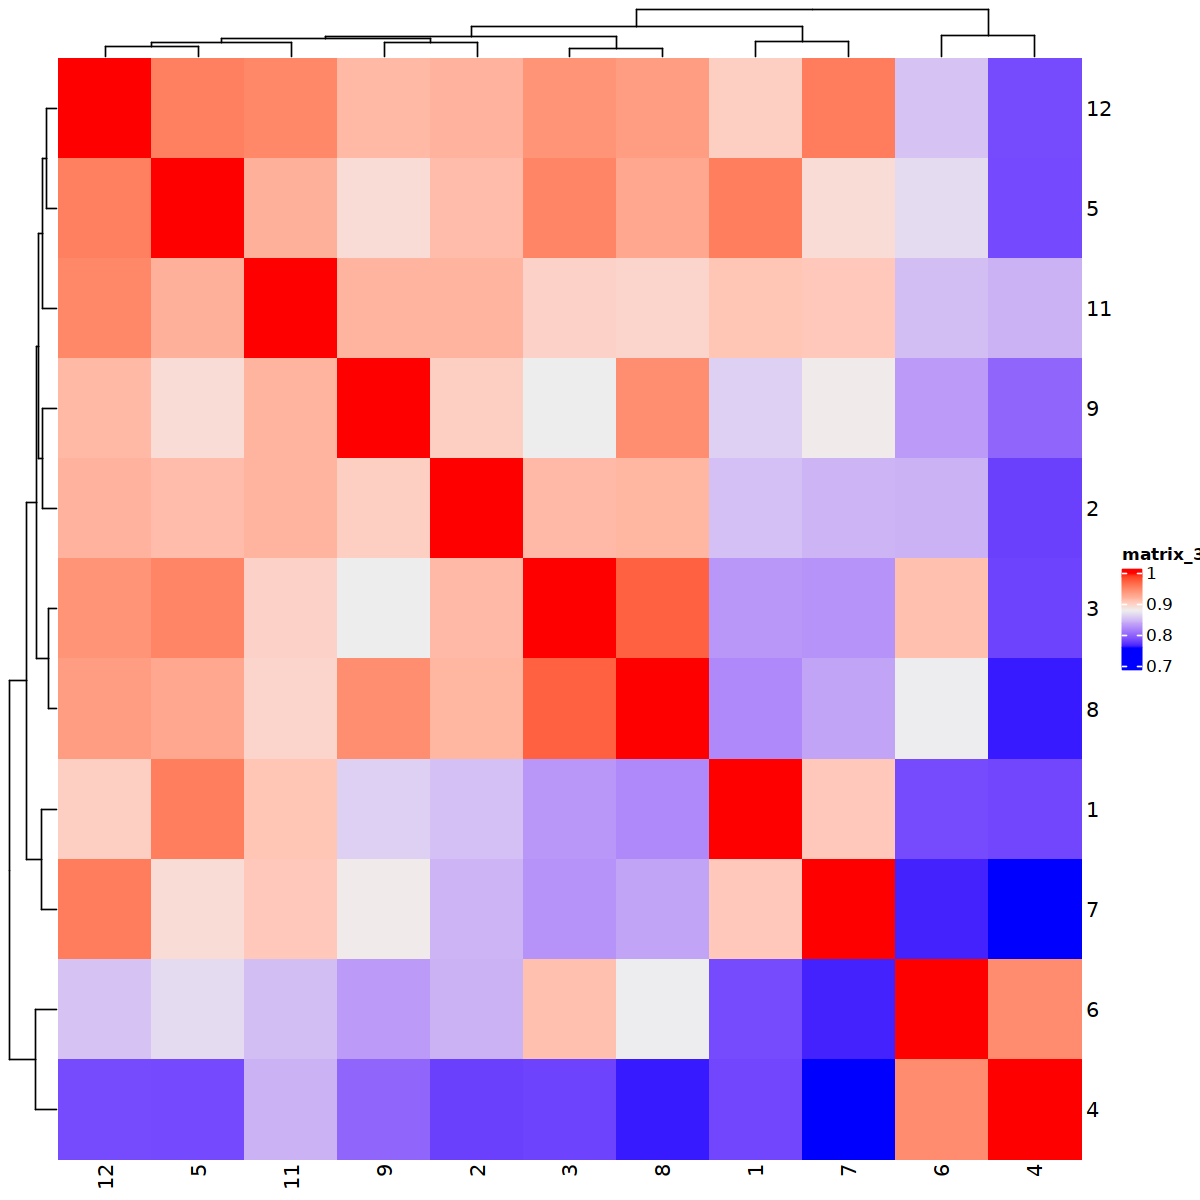

In [97]:
Proso_millet.leaf.corr <- marker_correlation(Proso_millet.leaf,
           meta_slot = "meta",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

library(modelr)
combined_louvain_clusters <- as_tibble(Proso_millet.leaf.corr$corr_matrix) %>%
    pivot_longer(!geneID, names_to = "cluster_name", values_to = "score")  %>% 
    group_by(geneID)  %>% 
      summarize(mean = mean(score),
            var = var(score))

regression <- loess(var ~ mean, data=combined_louvain_clusters)

combined_louvain_clusters.final <- combined_louvain_clusters %>% 
    add_residuals(regression)  %>% 
    arrange(resid, desc = FALSE)  %>% 
    top_n(500)

options(repr.plot.width=10, repr.plot.height=10)
corr_matrix <- Proso_millet.leaf.corr$corr_matrix

viz_matrix <- as_tibble(corr_matrix)  %>% 
    dplyr::filter(geneID %in% combined_louvain_clusters.final$geneID)  %>% 
    dplyr::select(-geneID)

Lc_corr_matrix <- cor(data.matrix(viz_matrix))

suppressPackageStartupMessages(library(ComplexHeatmap))
library(ComplexHeatmap)
Heatmap(Lc_corr_matrix)

In [68]:
grabbed_top_marker_per_cluster[c("rank", "7")]

rank 7         
1    1   RLN23970.1
2    2   RLN17493.1
3    3   RLN07950.1
4    4   RLM87540.1
5    5   RLM91851.1
6    6   RLN08846.1
7    7   RLM86416.1
8    8   RLN23123.1
9    9   RLN03794.1
10  10   RLN13488.1
11  11   RLN07952.1
12  12   RLN15755.1
13  13   RLN42931.1
14  14   RLN42941.1
15  15   RLN41209.1
16  16   RLN34875.1
17  17   RLM80941.1
18  18   RLM98897.1
19  19   RLN18775.1
20  20   RLM84728.1
21  21   RLN40259.1
22  22   RLN23419.1
23  23   RLN08025.1
24  24   RLM98859.1
25  25   RLN16928.1
26  26   RLN41079.1
27  27   RLN04722.1
28  28   RLN33031.1
29  29   RLM80932.1
30  30   RLN40459.1
⋮   ⋮    ⋮         
171 171  RLN00742.1
172 172  RLM99241.1
173 173  RLN22382.1
174 174  RLN36215.1
175 175  RLM79742.1
176 176  RLM85723.1
177 177  RLM64399.1
178 178  RLN16747.1
179 179  RLN41132.1
180 180  RLM61724.1
181 181  RLN25253.1
182 182  RLM84668.1
183 183  RLM87191.1
184 184  RLN39245.1
185 185  RLM91393.1
186 186  RLN24574.1
187 187  RLN16324.1
188 188  RLN23623.1
189 189  RLN12277.1
190 190  RLM60536.1
191 191  RLN39482.1
192 192  RLN43287.1
193 193  RLN34879.1
194 194  RLN42985.1
195 195  RLN15727.1
196 196  RLN35220.1
197 197  RLN43313.1
198 198  RLM60815.1
199 199  RLN23351.1
200 200  RLN34434.1

In [61]:
represented_marker_lst

[[1]]
# A tibble: 6 × 8
  geneID chr           start     stop gene_name        cell_type tissue LC_value
   <int> <chr>         <dbl>    <dbl> <chr>            <chr>     <chr>  <chr>   
1     14 CM009698.2 38623795 38629475 pepc1_ortho_cou… mesophyll axill… LC_1    
2     50 CM009695.2 18337364 18338001 ssu2_ortho_coun… bundle_s… axill… LC_1    
3     51 CM009702.2 27729766 27734305 bm5_ortho_count… vascular… axill… LC_1    
4     93 CM009699.2 23864157 23869377 pepc1_ortho_cou… mesophyll axill… LC_1    
5    103 CM009694.2 43870044 43870685 ssu2_ortho_coun… bundle_s… axill… LC_1    
6    154 CM009693.2 38093521 38098260 PDK1             mesophyll axill… LC_1    

[[2]]
NULL

[[3]]
# A tibble: 1 × 9
   rank `11`       geneID       start   stop gene_name cell_type tissue LC_value
  <int> <chr>      <chr>        <dbl>  <dbl> <chr>     <chr>     <chr>  <chr>   
1   195 RLM64975.1 CM009704.2  2.41e7 2.41e7 acl1_ort… bullifor… axill… LC_3    

[[4]]
# A tibble: 4 × 9
   rank `12`       chr         geneID   stop gene_name cell_type tissue LC_value
  <int> <chr>      <chr>        <dbl>  <dbl> <chr>     <chr>     <chr>  <chr>   
1     1 RLN23970.1 CM009693.2  2.33e7 2.33e7 gl1_orth… epidermis axill… LC_4    
2    13 RLN34875.1 CM009692.2  5.61e7 5.61e7 gl1_orth… epidermis axill… LC_4    
3   128 RLM73457.1 CM009703.2  1.95e7 1.95e7 bm5_orth… vascular… axill… LC_4    
4   142 RLM54978.1 CM009694.2  5.46e7 5.46e7 gpat11_o… epidermi… axill… LC_4    

[[5]]
# A tibble: 5 × 9
   rank `2`        chr          start geneID gene_name cell_type tissue LC_value
  <int> <chr>      <chr>        <dbl>  <dbl> <chr>     <chr>     <chr>  <chr>   
1    13 RLM85004.1 CM009698.2  3.86e7 3.86e7 pepc1_or… mesophyll axill… LC_5    
2    25 RLN29438.1 CM009694.2  4.39e7 4.39e7 ssu2_ort… bundle_s… axill… LC_5    
3    48 RLM79554.1 CM009695.2  1.83e7 1.83e7 ssu2_ort… bundle_s… axill… LC_5    
4    56 RLM93743.1 CM009699.2  2.39e7 2.39e7 pepc1_or… mesophyll axill… LC_5    
5   172 RLN15383.1 CM009702.2  2.77e7 2.77e7 bm5_orth… vascular… axill… LC_5    

[[6]]
# A tibble: 4 × 9
   rank `3`             chr        start   stop geneID cell_type tissue LC_value
  <int> <chr>           <chr>      <dbl>  <dbl> <chr>  <chr>     <chr>  <chr>   
1     1 RLM65673.1      CM009693… 2.33e7 2.33e7 gl1_o… epidermis axill… LC_6    
2    83 C2845_PMCG10012 CM009703… 1.95e7 1.95e7 bm5_o… vascular… axill… LC_6    
3   136 RLM73411.1      CM009692… 5.61e7 5.61e7 gl1_o… epidermis axill… LC_6    
4   151 RLM74340.1      CM009694… 5.46e7 5.46e7 gpat1… epidermi… axill… LC_6    

[[7]]
# A tibble: 5 × 9
   rank `4`        chr           start     stop gene_name geneID tissue LC_value
  <int> <chr>      <chr>         <dbl>    <dbl> <chr>     <chr>  <chr>  <chr>   
1    24 RLN00252.1 CM009695.2 18497032 18497666 ssu2_ort… bundl… axill… LC_7    
2    56 RLN04222.1 CM009694.2 43845043 43845676 ssu2_ort… bundl… axill… LC_7    
3    57 RLM64364.1 CM009701.2 36534715 36550893 brx_orth… phloe… axill… LC_7    
4   140 RLM58655.1 CM009691.2  4904978  4908147 bhlh43_o… bundl… axill… LC_7    
5   166 RLN12785.1 CM009696.2 35247169 35248071 cah6_ort… mesop… axill… LC_7